This notebook gives some examples of the Widely Applicable Information Criterion (WAIC) and its use with STAN.


The three cases considered are:
<ol>
<li>Linear Model vs Generalized Linear Model</li>
<li>Linear model feature selection </li>
<li>AR order determination </li>
</ol>

In [2]:
# this section imports stuff 
import pandas as pd
import numpy as np
import pystan
import matplotlib.pyplot as plt
import seaborn as sns
from pystan import StanModel
import arviz as az
from platform import python_version
import matplotlib.pyplot as plt
from orbit.utils.simulation import make_regression

In [3]:
%matplotlib inline

In [4]:
# check the things!
print('pandas: {}'.format(pd.__version__))
print('numpy: {}'.format(np.__version__))
print('pystan: {}'.format(pystan.__version__))
print(python_version())

pandas: 1.3.4
numpy: 1.21.4
pystan: 2.19.1.1
3.7.10


This section gives the WAIC function. For it to work the models must have a log probability of each observation for each sample. 

Note that the penalty term (k) is currently left as an argument to the user. In "Understanding predictive information criteria for Bayesian models” and "Practical Bayesian model evaluation using leave-one-out cross-validation and WAIC" k=2 is assumed. As is discussed here k = log(n) mighte be another choice. Note this is not WBIC which is its own thing. 



In [5]:
#WAIC
def WAIC(log_p, k = 2 ):
    P_WAIC2 = np.nansum(log_p.var(axis=0)) # the effective number of paramters 
    lppd = np.nansum(np.log(np.exp(log_p).mean(axis=0))) # the sum of log pointwise predictive density
    WAIC = -2*lppd +k* P_WAIC2 
    return WAIC, lppd, P_WAIC2



## First example:
This example considers the fitting of linear model with both a normal and a  Generalized normal distribution 

In [7]:
# make data 
n = 1000
x0 = np.ones(n)
x1 = np.random.normal(0, 10, n)
x2 = np.random.normal(0, 0.5, n)

X = np.vstack([x0, x1, x2]).transpose()


coefs = np.array([2.6, 0.2, 0.1])
yhat = np.matmul(X, coefs)
y = np.random.normal(yhat, 1)
print(X.shape)
print(y.shape)
print(coefs)

(1000, 3)
(1000,)
[2.6 0.2 0.1]


Four parts to a STAN process. Data, Model, Fitting, and outputs

In [8]:
# data
data = {
    'n_obs': len(y),
    'n_features': X.shape[1],
    'y': y,
    'X': X,
}

In [9]:
# make model 1 
model_code = """

    data {
      int<lower=0> n_obs;
      int<lower=0> n_features;
      vector[n_obs] y;
      // real y[n_obs];
      matrix[n_obs, n_features] X;
    }
    
    parameters{
      vector[n_features] beta;
      real<lower=0> sigma;
    }
    
    transformed parameters {
      vector[n_obs] yhat;
      vector[n_obs] log_p;
      yhat = X * beta;
      for (i in 1:n_obs)
        log_p[i] = normal_lpdf(y[i]|yhat[i], sigma);
    }
    
    model {

      y ~ normal(yhat, sigma);
    }
    
"""
sm_simple = StanModel(model_code=model_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_412e1436f24115a7272534d9976f78f6 NOW.
In file included from /var/folders/2r/w1lk3nxj09s73plknkyzzj5m0000gn/T/pystan_4z4ipu7f/stanfit4anon_model_412e1436f24115a7272534d9976f78f6_8675583257056951540.cpp:709:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/numpy/core/include/numpy/arrayobject.h:4:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/numpy/core/include/numpy/ndarrayobject.h:12:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/numpy/core/include/numpy/ndarraytypes.h:1969:
/Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/numpy/core/include/numpy/npy_1_7_deprecated_api.h:17:2: warning: "Using deprecated NumPy API, disable it with "          "#define NPY_NO_DEPRECATED_API NPY_1_7_API_VERSION" [-W#warnings]
#warning "Using deprecated NumPy API, di

In file included from /var/folders/2r/w1lk3nxj09s73plknkyzzj5m0000gn/T/pystan_4z4ipu7f/stanfit4anon_model_412e1436f24115a7272534d9976f78f6_8675583257056951540.cpp:718:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/py_var_context.hpp:12:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/stan/src/stan/io/dump.hpp:6:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat.hpp:9:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat/meta/as_array_or_scalar.hpp:4:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Dense:1:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/pytho

    call_dense_assignment_loop(dst, src, func);
    ^
/Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/src/Core/AssignEvaluator.h:836:46: note: in instantiation of member function 'Eigen::internal::Assignment<Eigen::Map<Eigen::Matrix<double, -1, 1, 0>, 2>, Eigen::Matrix<double, -1, 1, 0>, Eigen::internal::assign_op<double, double>, Eigen::internal::Dense2Dense, void>::run' requested here
  Assignment<ActualDstTypeCleaned,Src,Func>::run(actualDst, src, func);
                                             ^
/Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/src/Core/AssignEvaluator.h:804:3: note: in instantiation of function template specialization 'Eigen::internal::call_assignment_no_alias<Eigen::Map<Eigen::Matrix<double, -1, 1, 0>, 2>, Eigen::Matrix<double, -1, 1, 0>, Eigen::internal::assign_op<double, double>>' requested here
  call_ass

In file included from /var/folders/2r/w1lk3nxj09s73plknkyzzj5m0000gn/T/pystan_4z4ipu7f/stanfit4anon_model_412e1436f24115a7272534d9976f78f6_8675583257056951540.cpp:719:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/stan_fit.hpp:15:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/stan/lib/stan_math/lib/boost_1.69.0/boost/random/additive_combine.hpp:27:
/Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/stan/lib/stan_math/lib/boost_1.69.0/boost/random/linear_congruential.hpp:140:20: warning: overlapping comparisons always evaluate to false [-Wtautological-overlap-compare]
        if(_x <= 0 && _x != 0) {
           ~~~~~~~~^~~~~~~~~~
/Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/stan/lib/stan_math/lib/boost_1.69.0/boost/random/linear_congruential.hpp:393:11: note: in instantiation of member function

In file included from /var/folders/2r/w1lk3nxj09s73plknkyzzj5m0000gn/T/pystan_4z4ipu7f/stanfit4anon_model_412e1436f24115a7272534d9976f78f6_8675583257056951540.cpp:718:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/py_var_context.hpp:12:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/stan/src/stan/io/dump.hpp:6:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat.hpp:9:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat/meta/as_array_or_scalar.hpp:4:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Dense:1:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/pytho

In file included from /var/folders/2r/w1lk3nxj09s73plknkyzzj5m0000gn/T/pystan_4z4ipu7f/stanfit4anon_model_412e1436f24115a7272534d9976f78f6_8675583257056951540.cpp:718:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/py_var_context.hpp:12:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/stan/src/stan/io/dump.hpp:6:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat.hpp:9:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat/meta/as_array_or_scalar.hpp:4:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Dense:1:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/pytho

In file included from /var/folders/2r/w1lk3nxj09s73plknkyzzj5m0000gn/T/pystan_4z4ipu7f/stanfit4anon_model_412e1436f24115a7272534d9976f78f6_8675583257056951540.cpp:719:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/stan_fit.hpp:15:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/stan/lib/stan_math/lib/boost_1.69.0/boost/random/additive_combine.hpp:27:
/Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/stan/lib/stan_math/lib/boost_1.69.0/boost/random/linear_congruential.hpp:140:20: warning: overlapping comparisons always evaluate to false [-Wtautological-overlap-compare]
        if(_x <= 0 && _x != 0) {
           ~~~~~~~~^~~~~~~~~~
/Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/stan/lib/stan_math/lib/boost_1.69.0/boost/random/additive_combine.hpp:82:16: note: in instantiation of member function 'bo

In file included from /var/folders/2r/w1lk3nxj09s73plknkyzzj5m0000gn/T/pystan_4z4ipu7f/stanfit4anon_model_412e1436f24115a7272534d9976f78f6_8675583257056951540.cpp:718:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/py_var_context.hpp:12:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/stan/src/stan/io/dump.hpp:6:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat.hpp:9:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat/meta/as_array_or_scalar.hpp:4:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Dense:1:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/pytho

In file included from /var/folders/2r/w1lk3nxj09s73plknkyzzj5m0000gn/T/pystan_4z4ipu7f/stanfit4anon_model_412e1436f24115a7272534d9976f78f6_8675583257056951540.cpp:718:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/py_var_context.hpp:12:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/stan/src/stan/io/dump.hpp:6:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat.hpp:9:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat/meta/as_array_or_scalar.hpp:4:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Dense:1:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/pytho

In file included from /var/folders/2r/w1lk3nxj09s73plknkyzzj5m0000gn/T/pystan_4z4ipu7f/stanfit4anon_model_412e1436f24115a7272534d9976f78f6_8675583257056951540.cpp:718:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/py_var_context.hpp:12:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/stan/src/stan/io/dump.hpp:6:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat.hpp:9:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat/meta/as_array_or_scalar.hpp:4:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Dense:1:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/pytho

In file included from /var/folders/2r/w1lk3nxj09s73plknkyzzj5m0000gn/T/pystan_4z4ipu7f/stanfit4anon_model_412e1436f24115a7272534d9976f78f6_8675583257056951540.cpp:718:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/py_var_context.hpp:12:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/stan/src/stan/io/dump.hpp:6:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat.hpp:9:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat/meta/as_array_or_scalar.hpp:4:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Dense:1:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/pytho

In file included from /var/folders/2r/w1lk3nxj09s73plknkyzzj5m0000gn/T/pystan_4z4ipu7f/stanfit4anon_model_412e1436f24115a7272534d9976f78f6_8675583257056951540.cpp:718:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/py_var_context.hpp:12:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/stan/src/stan/io/dump.hpp:6:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat.hpp:9:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat/meta/as_array_or_scalar.hpp:4:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Dense:1:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/pytho

In file included from /var/folders/2r/w1lk3nxj09s73plknkyzzj5m0000gn/T/pystan_4z4ipu7f/stanfit4anon_model_412e1436f24115a7272534d9976f78f6_8675583257056951540.cpp:718:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/py_var_context.hpp:12:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/stan/src/stan/io/dump.hpp:6:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat.hpp:9:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat/meta/as_array_or_scalar.hpp:4:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Dense:1:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/pytho

155 warnings generated.


In [10]:
# make model 2 
model_code = """
    functions{
    real gen_norm_lpdf(real x, real alpha, real beta, real mu){
        return(log(beta) - log(2*alpha)- lgamma(1/beta) - pow(fabs(x-mu)/alpha, beta) );        
        }
    }


    data {
      int<lower=0> n_obs;
      int<lower=0> n_features;
      vector[n_obs] y;
      // real y[n_obs];
      matrix[n_obs, n_features] X;
    }
    

    
    parameters{
      vector[n_features] m;
      real<lower=0> alpha;
      real<lower=0,upper=5> beta;
    }
    
    transformed parameters {
      vector[n_obs] yhat;
      vector[n_obs] log_p;
      yhat = X * m;
      for (i in 1:n_obs)
          log_p[i] = log(beta) - log(2*alpha)- lgamma(1/beta) - pow(fabs(y[i]-yhat[i])/alpha, beta);
    }
    
    model {
      //vector[n_obs] yhat;
      //yhat = X * m;
      alpha ~ uniform(0, 10);
      beta ~ uniform(0, 5);
      
      for (i in 1:n_obs)
          target += gen_norm_lpdf(y[i]| alpha, beta, yhat[i] );
      //y ~ normal(yhat, alpha);
    }
    
"""
sm_complex = StanModel(model_code=model_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_b4b8122407a34d7b8cd18507d807e8a2 NOW.
In file included from /var/folders/2r/w1lk3nxj09s73plknkyzzj5m0000gn/T/pystan_umj6jsfk/stanfit4anon_model_b4b8122407a34d7b8cd18507d807e8a2_2892134801688316521.cpp:709:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/numpy/core/include/numpy/arrayobject.h:4:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/numpy/core/include/numpy/ndarrayobject.h:12:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/numpy/core/include/numpy/ndarraytypes.h:1969:
/Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/numpy/core/include/numpy/npy_1_7_deprecated_api.h:17:2: warning: "Using deprecated NumPy API, disable it with "          "#define NPY_NO_DEPRECATED_API NPY_1_7_API_VERSION" [-W#warnings]
#warning "Using deprecated NumPy API, di

In file included from /var/folders/2r/w1lk3nxj09s73plknkyzzj5m0000gn/T/pystan_umj6jsfk/stanfit4anon_model_b4b8122407a34d7b8cd18507d807e8a2_2892134801688316521.cpp:718:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/py_var_context.hpp:12:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/stan/src/stan/io/dump.hpp:6:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat.hpp:9:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat/meta/as_array_or_scalar.hpp:4:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Dense:1:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/pytho

In file included from /var/folders/2r/w1lk3nxj09s73plknkyzzj5m0000gn/T/pystan_umj6jsfk/stanfit4anon_model_b4b8122407a34d7b8cd18507d807e8a2_2892134801688316521.cpp:718:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/py_var_context.hpp:12:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/stan/src/stan/io/dump.hpp:6:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat.hpp:9:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat/meta/as_array_or_scalar.hpp:4:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Dense:1:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/pytho

In file included from /var/folders/2r/w1lk3nxj09s73plknkyzzj5m0000gn/T/pystan_umj6jsfk/stanfit4anon_model_b4b8122407a34d7b8cd18507d807e8a2_2892134801688316521.cpp:719:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/stan_fit.hpp:15:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/stan/lib/stan_math/lib/boost_1.69.0/boost/random/additive_combine.hpp:27:
/Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/stan/lib/stan_math/lib/boost_1.69.0/boost/random/linear_congruential.hpp:140:20: warning: overlapping comparisons always evaluate to false [-Wtautological-overlap-compare]
        if(_x <= 0 && _x != 0) {
           ~~~~~~~~^~~~~~~~~~
/Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/stan/lib/stan_math/lib/boost_1.69.0/boost/random/linear_congruential.hpp:393:11: note: in instantiation of member function

In file included from /var/folders/2r/w1lk3nxj09s73plknkyzzj5m0000gn/T/pystan_umj6jsfk/stanfit4anon_model_b4b8122407a34d7b8cd18507d807e8a2_2892134801688316521.cpp:718:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/py_var_context.hpp:12:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/stan/src/stan/io/dump.hpp:6:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat.hpp:9:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat/meta/as_array_or_scalar.hpp:4:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Dense:1:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/pytho

In file included from /var/folders/2r/w1lk3nxj09s73plknkyzzj5m0000gn/T/pystan_umj6jsfk/stanfit4anon_model_b4b8122407a34d7b8cd18507d807e8a2_2892134801688316521.cpp:718:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/py_var_context.hpp:12:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/stan/src/stan/io/dump.hpp:6:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat.hpp:9:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat/meta/as_array_or_scalar.hpp:4:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Dense:1:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/pytho

In file included from /var/folders/2r/w1lk3nxj09s73plknkyzzj5m0000gn/T/pystan_umj6jsfk/stanfit4anon_model_b4b8122407a34d7b8cd18507d807e8a2_2892134801688316521.cpp:718:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/py_var_context.hpp:12:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/stan/src/stan/io/dump.hpp:6:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat.hpp:9:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat/meta/as_array_or_scalar.hpp:4:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Dense:1:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/pytho

In file included from /var/folders/2r/w1lk3nxj09s73plknkyzzj5m0000gn/T/pystan_umj6jsfk/stanfit4anon_model_b4b8122407a34d7b8cd18507d807e8a2_2892134801688316521.cpp:718:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/py_var_context.hpp:12:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/stan/src/stan/io/dump.hpp:6:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat.hpp:9:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat/meta/as_array_or_scalar.hpp:4:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Dense:1:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/pytho

In file included from /var/folders/2r/w1lk3nxj09s73plknkyzzj5m0000gn/T/pystan_umj6jsfk/stanfit4anon_model_b4b8122407a34d7b8cd18507d807e8a2_2892134801688316521.cpp:718:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/py_var_context.hpp:12:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/stan/src/stan/io/dump.hpp:6:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat.hpp:9:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat/meta/as_array_or_scalar.hpp:4:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Dense:1:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/pytho

In file included from /var/folders/2r/w1lk3nxj09s73plknkyzzj5m0000gn/T/pystan_umj6jsfk/stanfit4anon_model_b4b8122407a34d7b8cd18507d807e8a2_2892134801688316521.cpp:718:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/py_var_context.hpp:12:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/stan/src/stan/io/dump.hpp:6:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat.hpp:9:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat/meta/as_array_or_scalar.hpp:4:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Dense:1:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/pytho

/Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/src/Core/AssignEvaluator.h:836:46: note: in instantiation of member function 'Eigen::internal::Assignment<Eigen::Matrix<double, -1, 1, 0>, Eigen::CwiseBinaryOp<Eigen::internal::scalar_product_op<double>, const Eigen::CwiseNullaryOp<Eigen::internal::scalar_constant_op<double>, const Eigen::Matrix<double, -1, 1, 0>>, const Eigen::Matrix<double, -1, 1, 0>>, Eigen::internal::assign_op<double, double>, Eigen::internal::Dense2Dense, void>::run' requested here
  Assignment<ActualDstTypeCleaned,Src,Func>::run(actualDst, src, func);
                                             ^
/Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/src/Core/PlainObjectBase.h:728:17: note: in instantiation of function template specialization 'Eigen::internal::call_assignment_no_alias<Eigen::Matrix<double, -1, 1, 0>, E

In file included from /var/folders/2r/w1lk3nxj09s73plknkyzzj5m0000gn/T/pystan_umj6jsfk/stanfit4anon_model_b4b8122407a34d7b8cd18507d807e8a2_2892134801688316521.cpp:718:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/py_var_context.hpp:12:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/stan/src/stan/io/dump.hpp:6:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat.hpp:9:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat/meta/as_array_or_scalar.hpp:4:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Dense:1:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/pytho

155 warnings generated.


In [11]:
# fit the models 
fit_simple = sm_simple.sampling(data=data, iter=10000, chains=4, verbose =True)
fit_complex = sm_complex.sampling(data=data, iter=10000, chains=4, verbose =True)


Gradient evaluation took 0.000264 seconds
1000 transitions using 10 leapfrog steps per transition would take 2.64 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.000197 seconds
1000 transitions using 10 leapfrog steps per transition would take 1.97 seconds.
Adjust your expectations accordingly!


Iteration:    1 / 10000 [  0%]  (Warmup)

Gradient evaluation took 0.000217 seconds
1000 transitions using 10 leapfrog steps per transition would take 2.17 seconds.
Adjust your expectations accordingly!


Iteration:    1 / 10000 [  0%]  (Warmup)
Iteration:    1 / 10000 [  0%]  (Warmup)

Gradient evaluation took 0.000158 seconds
1000 transitions using 10 leapfrog steps per transition would take 1.58 seconds.
Adjust your expectations accordingly!


Iteration:    1 / 10000 [  0%]  (Warmup)
Iteration: 1000 / 10000 [ 10%]  (Warmup)
Iteration: 1000 / 10000 [ 10%]  (Warmup)
Iteration: 1000 / 10000 [ 10%]  (Warmup)
Iteration: 1000 / 10000 [ 10%]  (Warmup)
Iteration: 2000 

To run all diagnostics call pystan.check_hmc_diagnostics(fit)



Gradient evaluation took 0.0008 seconds
1000 transitions using 10 leapfrog steps per transition would take 8 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.000998 seconds
1000 transitions using 10 leapfrog steps per transition would take 9.98 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.000971 seconds
1000 transitions using 10 leapfrog steps per transition would take 9.71 seconds.
Adjust your expectations accordingly!


Iteration:    1 / 10000 [  0%]  (Warmup)
Iteration:    1 / 10000 [  0%]  (Warmup)
Iteration:    1 / 10000 [  0%]  (Warmup)

Gradient evaluation took 0.000814 seconds
1000 transitions using 10 leapfrog steps per transition would take 8.14 seconds.
Adjust your expectations accordingly!


Iteration:    1 / 10000 [  0%]  (Warmup)
Iteration: 1000 / 10000 [ 10%]  (Warmup)
Iteration: 1000 / 10000 [ 10%]  (Warmup)
Iteration: 1000 / 10000 [ 10%]  (Warmup)
Iteration: 1000 / 10000 [ 10%]  (Warmup)
Iteration: 2000 / 100

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


In [15]:
# extract the posteriors
posteriors_simple = fit_simple.extract(permuted=True)  # return a dictionary of arrays
print(posteriors_simple.keys())

posteriors_complex = fit_complex.extract(permuted=True)  # return a dictionary of arrays
print(posteriors_complex.keys())

odict_keys(['beta', 'sigma', 'yhat', 'log_p', 'lp__'])
odict_keys(['m', 'alpha', 'beta', 'yhat', 'log_p', 'lp__'])


In [14]:

WAIC_s, lppd_s, P_WAIC2_s = WAIC(log_p = posteriors_simple['log_p'])
WAIC_c, lppd_c, P_WAIC2_c = WAIC(log_p = posteriors_complex['log_p'])

print("WAIC")
print(WAIC_s)
print(WAIC_c)

print("Effective # Pars")
print(P_WAIC2_s)
print(P_WAIC2_c)

print("log pointwise predictive density")
print(lppd_s)
print(lppd_c)


    

WAIC
2850.4000825244043
2852.1189374564096
Effective # Pars
4.074875990581123
5.070084502973484
log pointwise predictive density
-1421.125165271621
-1420.9893842252313


The above should show that simple model is about 2 points better than the complex. The complex has one more parameter and should have about the same LPPD.

## Example 2
Feature selection for linear models with WAIC.

In [40]:
# make data 
n = 1000
x0 = np.ones(n)
x1 = np.random.normal(0, 1, n)
x2 = np.random.normal(0, 1, n)
x3 = np.random.normal(0, 1, n)
x4 = np.random.normal(0, 1, n)
x5 = np.random.normal(0, 1, n)
x6 = np.random.normal(0, 1, n)
x7 = np.random.normal(0, 1, n)
x8 = np.random.normal(0, 1, n)
x9 = np.random.normal(0, 1, n)

X9 = np.vstack([x0, x1, x2, x3, x4, x5, x6, x7, x8, x9]).transpose()
X = np.vstack([x0, x1, x2]).transpose()
coefs = np.array([2.6, 0.2, 0.1])
yhat = np.matmul(X, coefs)
y = np.random.normal(yhat, 1)
print(X.shape)
print(y.shape)
print(coefs)

(1000, 3)
(1000,)
[2.6 0.2 0.1]


In [41]:
data = {
    'n_obs': len(y),
    'n_features': X.shape[1],
    'y': y,
    'X': X,
}

In [42]:

model_code = """

    data {
      int<lower=0> n_obs;
      int<lower=0> n_features;
      vector[n_obs] y;
      // real y[n_obs];
      matrix[n_obs, n_features] X;
    }
    
    parameters{
      vector[n_features] beta;
      real<lower=0> sigma;
    }
    
    transformed parameters {
      vector[n_obs] yhat;
      vector[n_obs] log_p;
      yhat = X * beta;
      for (i in 1:n_obs)
        log_p[i] = normal_lpdf(y[i]|yhat[i], sigma);
    }
    
    model {

      y ~ normal(yhat, sigma);
    }
    
"""
sm_temp = StanModel(model_code=model_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_412e1436f24115a7272534d9976f78f6 NOW.
In file included from /var/folders/2r/w1lk3nxj09s73plknkyzzj5m0000gn/T/pystan_af0yknq6/stanfit4anon_model_412e1436f24115a7272534d9976f78f6_3189404493915394041.cpp:709:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/numpy/core/include/numpy/arrayobject.h:4:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/numpy/core/include/numpy/ndarrayobject.h:12:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/numpy/core/include/numpy/ndarraytypes.h:1969:
/Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/numpy/core/include/numpy/npy_1_7_deprecated_api.h:17:2: warning: "Using deprecated NumPy API, disable it with "          "#define NPY_NO_DEPRECATED_API NPY_1_7_API_VERSION" [-W#warnings]
#warning "Using deprecated NumPy API, di

In file included from /var/folders/2r/w1lk3nxj09s73plknkyzzj5m0000gn/T/pystan_af0yknq6/stanfit4anon_model_412e1436f24115a7272534d9976f78f6_3189404493915394041.cpp:718:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/py_var_context.hpp:12:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/stan/src/stan/io/dump.hpp:6:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat.hpp:9:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat/meta/as_array_or_scalar.hpp:4:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Dense:1:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/pytho

In file included from /var/folders/2r/w1lk3nxj09s73plknkyzzj5m0000gn/T/pystan_af0yknq6/stanfit4anon_model_412e1436f24115a7272534d9976f78f6_3189404493915394041.cpp:718:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/py_var_context.hpp:12:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/stan/src/stan/io/dump.hpp:6:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat.hpp:9:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat/meta/as_array_or_scalar.hpp:4:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Dense:1:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/pytho

In file included from /var/folders/2r/w1lk3nxj09s73plknkyzzj5m0000gn/T/pystan_af0yknq6/stanfit4anon_model_412e1436f24115a7272534d9976f78f6_3189404493915394041.cpp:719:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/stan_fit.hpp:15:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/stan/lib/stan_math/lib/boost_1.69.0/boost/random/additive_combine.hpp:27:
/Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/stan/lib/stan_math/lib/boost_1.69.0/boost/random/linear_congruential.hpp:140:20: warning: overlapping comparisons always evaluate to false [-Wtautological-overlap-compare]
        if(_x <= 0 && _x != 0) {
           ~~~~~~~~^~~~~~~~~~
/Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/stan/lib/stan_math/lib/boost_1.69.0/boost/random/linear_congruential.hpp:393:11: note: in instantiation of member function

In file included from /var/folders/2r/w1lk3nxj09s73plknkyzzj5m0000gn/T/pystan_af0yknq6/stanfit4anon_model_412e1436f24115a7272534d9976f78f6_3189404493915394041.cpp:718:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/py_var_context.hpp:12:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/stan/src/stan/io/dump.hpp:6:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat.hpp:9:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat/meta/as_array_or_scalar.hpp:4:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Dense:1:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/pytho

In file included from /var/folders/2r/w1lk3nxj09s73plknkyzzj5m0000gn/T/pystan_af0yknq6/stanfit4anon_model_412e1436f24115a7272534d9976f78f6_3189404493915394041.cpp:718:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/py_var_context.hpp:12:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/stan/src/stan/io/dump.hpp:6:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat.hpp:9:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat/meta/as_array_or_scalar.hpp:4:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Dense:1:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/pytho

In file included from /var/folders/2r/w1lk3nxj09s73plknkyzzj5m0000gn/T/pystan_af0yknq6/stanfit4anon_model_412e1436f24115a7272534d9976f78f6_3189404493915394041.cpp:718:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/py_var_context.hpp:12:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/stan/src/stan/io/dump.hpp:6:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat.hpp:9:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat/meta/as_array_or_scalar.hpp:4:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Dense:1:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/pytho

In file included from /var/folders/2r/w1lk3nxj09s73plknkyzzj5m0000gn/T/pystan_af0yknq6/stanfit4anon_model_412e1436f24115a7272534d9976f78f6_3189404493915394041.cpp:718:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/py_var_context.hpp:12:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/stan/src/stan/io/dump.hpp:6:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat.hpp:9:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat/meta/as_array_or_scalar.hpp:4:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Dense:1:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/pytho

In file included from /var/folders/2r/w1lk3nxj09s73plknkyzzj5m0000gn/T/pystan_af0yknq6/stanfit4anon_model_412e1436f24115a7272534d9976f78f6_3189404493915394041.cpp:718:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/py_var_context.hpp:12:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/stan/src/stan/io/dump.hpp:6:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat.hpp:9:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat/meta/as_array_or_scalar.hpp:4:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Dense:1:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/pytho

In file included from /var/folders/2r/w1lk3nxj09s73plknkyzzj5m0000gn/T/pystan_af0yknq6/stanfit4anon_model_412e1436f24115a7272534d9976f78f6_3189404493915394041.cpp:718:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/py_var_context.hpp:12:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/stan/src/stan/io/dump.hpp:6:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat.hpp:9:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat/meta/as_array_or_scalar.hpp:4:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Dense:1:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/pytho

In file included from /var/folders/2r/w1lk3nxj09s73plknkyzzj5m0000gn/T/pystan_af0yknq6/stanfit4anon_model_412e1436f24115a7272534d9976f78f6_3189404493915394041.cpp:718:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/py_var_context.hpp:12:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/stan/src/stan/io/dump.hpp:6:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat.hpp:9:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat/meta/as_array_or_scalar.hpp:4:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Dense:1:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/pytho

In file included from /var/folders/2r/w1lk3nxj09s73plknkyzzj5m0000gn/T/pystan_af0yknq6/stanfit4anon_model_412e1436f24115a7272534d9976f78f6_3189404493915394041.cpp:718:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/py_var_context.hpp:12:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/stan/src/stan/io/dump.hpp:6:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat.hpp:9:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat/meta/as_array_or_scalar.hpp:4:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Dense:1:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/pytho

155 warnings generated.


In [43]:
# this cell loops through models with different number of features
WAIC_list = np.zeros((10))
lppd_list = np.zeros((10))
p_list = np.zeros((10))

for i in range(1, 10):
    X = X9.copy()
    X = X[:,:i]
    print(X.shape[1])
    data = {
        'n_obs': len(y),
        'n_features': X.shape[1],
        'y': y,
        'X': X,
    }
    
    fit_temp = sm_temp.sampling(data=data, iter=2000, chains=4, verbose =False)
    posteriors_temp = fit_temp.extract(permuted=True)
    WAIC_v, lppd, P_WAIC2 = WAIC(log_p = posteriors_temp['log_p'])
    WAIC_list[i-1] = WAIC_v
    lppd_list[i-1] = lppd
    p_list[i-1] = P_WAIC2  
    
    print("-------------------------------------------------------------------------------")
    print(i)
    print(WAIC_v)
    print("-------------------------------------------------------------------------------")    
    
    
    

1

Gradient evaluation took 0.000304 seconds
1000 transitions using 10 leapfrog steps per transition would take 3.04 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.000308 seconds
1000 transitions using 10 leapfrog steps per transition would take 3.08 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.000228 seconds
1000 transitions using 10 leapfrog steps per transition would take 2.28 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.000205 seconds
1000 transitions using 10 leapfrog steps per transition would take 2.05 seconds.
Adjust your expectations accordingly!


Iteration:    1 / 2000 [  0%]  (Warmup)
Iteration:    1 / 2000 [  0%]  (Warmup)
Iteration:    1 / 2000 [  0%]  (Warmup)
Iteration:    1 / 2000 [  0%]  (Warmup)
Iteration:  200 / 2000 [ 10%]  (Warmup)
Iteration:  200 / 2000 [ 10%]  (Warmup)
Iteration:  200 / 2000 [ 10%]  (Warmup)
Iteration:  200 / 2000 [ 10%]  (Warmup)
Iteration:  400 / 2000

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: normal_lpdf: Scale parameter is 0, but must be > 0!  (in 'unknown file name' at line 21)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: normal_lpdf: Scale parameter is 0, but must be > 0!  (in 'unknown file name' at line 21)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.



Iteration:  600 / 2000 [ 30%]  (Warmup)
Iteration:  600 / 2000 [ 30%]  (Warmup)
Iteration:  600 / 2000 [ 30%]  (Warmup)
Iteration:  600 / 2000 [ 30%]  (Warmup)
Iteration:  800 / 2000 [ 40%]  (Warmup)
Iteration:  800 / 2000 [ 40%]  (Warmup)
Iteration:  800 / 2000 [ 40%]  (Warmup)
Iteration:  800 / 2000 [ 40%]  (Warmup)
Iteration: 1000 / 2000 [ 50%]  (Warmup)
Iteration: 1001 / 2000 [ 50%]  (Sampling)
Iteration: 1000 / 2000 [ 50%]  (Warmup)
Iteration: 1001 / 2000 [ 50%]  (Sampling)
Iteration: 1000 / 2000 [ 50%]  (Warmup)
Iteration: 1001 / 2000 [ 50%]  (Sampling)
Iteration: 1200 / 2000 [ 60%]  (Sampling)
Iteration: 1000 / 2000 [ 50%]  (Warmup)
Iteration: 1001 / 2000 [ 50%]  (Sampling)
Iteration: 1200 / 2000 [ 60%]  (Sampling)
Iteration: 1200 / 2000 [ 60%]  (Sampling)
Iteration: 1400 / 2000 [ 70%]  (Sampling)
Iteration: 1200 / 2000 [ 60%]  (Sampling)
Iteration: 1600 / 2000 [ 80%]  (Sampling)
Iteration: 1800 / 2000 [ 90%]  (Sampling)
Iteration: 1400 / 2000 [ 70%]  (Sampling)
Iteration: 1400 

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


-------------------------------------------------------------------------------
1
2864.764395297331
-------------------------------------------------------------------------------
2

Gradient evaluation took 0.000384 seconds
1000 transitions using 10 leapfrog steps per transition would take 3.84 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.000332 seconds
1000 transitions using 10 leapfrog steps per transition would take 3.32 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.000624 seconds
1000 transitions using 10 leapfrog steps per transition would take 6.24 seconds.
Adjust your expectations accordingly!


Iteration:    1 / 2000 [  0%]  (Warmup)
Iteration:    1 / 2000 [  0%]  (Warmup)

Gradient evaluation took 0.00028 seconds
1000 transitions using 10 leapfrog steps per transition would take 2.8 seconds.
Adjust your expectations accordingly!


Iteration:    1 / 2000 [  0%]  (Warmup)
Iteration:    1 / 2000 [  0%]  (Warmup)
Iter

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: normal_lpdf: Scale parameter is 0, but must be > 0!  (in 'unknown file name' at line 21)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: normal_lpdf: Scale parameter is 0, but must be > 0!  (in 'unknown file name' at line 21)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.



Iteration:  600 / 2000 [ 30%]  (Warmup)
Iteration:  600 / 2000 [ 30%]  (Warmup)
Iteration:  600 / 2000 [ 30%]  (Warmup)
Iteration:  600 / 2000 [ 30%]  (Warmup)
Iteration:  800 / 2000 [ 40%]  (Warmup)
Iteration:  800 / 2000 [ 40%]  (Warmup)
Iteration:  800 / 2000 [ 40%]  (Warmup)
Iteration:  800 / 2000 [ 40%]  (Warmup)
Iteration: 1000 / 2000 [ 50%]  (Warmup)
Iteration: 1001 / 2000 [ 50%]  (Sampling)
Iteration: 1000 / 2000 [ 50%]  (Warmup)
Iteration: 1001 / 2000 [ 50%]  (Sampling)
Iteration: 1000 / 2000 [ 50%]  (Warmup)
Iteration: 1001 / 2000 [ 50%]  (Sampling)
Iteration: 1000 / 2000 [ 50%]  (Warmup)
Iteration: 1001 / 2000 [ 50%]  (Sampling)
Iteration: 1200 / 2000 [ 60%]  (Sampling)
Iteration: 1200 / 2000 [ 60%]  (Sampling)
Iteration: 1200 / 2000 [ 60%]  (Sampling)
Iteration: 1200 / 2000 [ 60%]  (Sampling)
Iteration: 1400 / 2000 [ 70%]  (Sampling)
Iteration: 1400 / 2000 [ 70%]  (Sampling)
Iteration: 1400 / 2000 [ 70%]  (Sampling)
Iteration: 1600 / 2000 [ 80%]  (Sampling)
Iteration: 1400 

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


-------------------------------------------------------------------------------
2
2818.5539702670826
-------------------------------------------------------------------------------
3

Gradient evaluation took 0.000312 seconds
1000 transitions using 10 leapfrog steps per transition would take 3.12 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.000322 seconds
1000 transitions using 10 leapfrog steps per transition would take 3.22 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.000304 seconds
1000 transitions using 10 leapfrog steps per transition would take 3.04 seconds.
Adjust your expectations accordingly!


Iteration:    1 / 2000 [  0%]  (Warmup)

Gradient evaluation took 0.000255 seconds
1000 transitions using 10 leapfrog steps per transition would take 2.55 seconds.
Adjust your expectations accordingly!


Iteration:    1 / 2000 [  0%]  (Warmup)
Iteration:    1 / 2000 [  0%]  (Warmup)
Iteration:    1 / 2000 [  0%]  (Warmup)
I

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: normal_lpdf: Scale parameter is 0, but must be > 0!  (in 'unknown file name' at line 21)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: normal_lpdf: Scale parameter is 0, but must be > 0!  (in 'unknown file name' at line 21)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.



Iteration:  600 / 2000 [ 30%]  (Warmup)
Iteration:  600 / 2000 [ 30%]  (Warmup)
Iteration:  600 / 2000 [ 30%]  (Warmup)
Iteration:  600 / 2000 [ 30%]  (Warmup)
Iteration:  800 / 2000 [ 40%]  (Warmup)
Iteration:  800 / 2000 [ 40%]  (Warmup)
Iteration:  800 / 2000 [ 40%]  (Warmup)
Iteration:  800 / 2000 [ 40%]  (Warmup)
Iteration: 1000 / 2000 [ 50%]  (Warmup)
Iteration: 1001 / 2000 [ 50%]  (Sampling)
Iteration: 1000 / 2000 [ 50%]  (Warmup)
Iteration: 1001 / 2000 [ 50%]  (Sampling)
Iteration: 1000 / 2000 [ 50%]  (Warmup)
Iteration: 1001 / 2000 [ 50%]  (Sampling)
Iteration: 1000 / 2000 [ 50%]  (Warmup)
Iteration: 1001 / 2000 [ 50%]  (Sampling)
Iteration: 1200 / 2000 [ 60%]  (Sampling)
Iteration: 1200 / 2000 [ 60%]  (Sampling)
Iteration: 1200 / 2000 [ 60%]  (Sampling)
Iteration: 1400 / 2000 [ 70%]  (Sampling)
Iteration: 1400 / 2000 [ 70%]  (Sampling)
Iteration: 1200 / 2000 [ 60%]  (Sampling)
Iteration: 1400 / 2000 [ 70%]  (Sampling)
Iteration: 1600 / 2000 [ 80%]  (Sampling)
Iteration: 1600 

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


-------------------------------------------------------------------------------
3
2793.632265255118
-------------------------------------------------------------------------------
4

Gradient evaluation took 0.000328 seconds
1000 transitions using 10 leapfrog steps per transition would take 3.28 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.000302 seconds
1000 transitions using 10 leapfrog steps per transition would take 3.02 seconds.
Adjust your expectations accordingly!


Iteration:    1 / 2000 [  0%]  (Warmup)

Gradient evaluation took 0.000509 seconds
1000 transitions using 10 leapfrog steps per transition would take 5.09 seconds.
Adjust your expectations accordingly!


Iteration:    1 / 2000 [  0%]  (Warmup)

Gradient evaluation took 0.000286 seconds
1000 transitions using 10 leapfrog steps per transition would take 2.86 seconds.
Adjust your expectations accordingly!


Iteration:    1 / 2000 [  0%]  (Warmup)
Iteration:    1 / 2000 [  0%]  (Warmup)
It

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: normal_lpdf: Scale parameter is 0, but must be > 0!  (in 'unknown file name' at line 21)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.



Iteration:  400 / 2000 [ 20%]  (Warmup)
Iteration:  400 / 2000 [ 20%]  (Warmup)
Iteration:  400 / 2000 [ 20%]  (Warmup)
Iteration:  600 / 2000 [ 30%]  (Warmup)
Iteration:  600 / 2000 [ 30%]  (Warmup)
Iteration:  600 / 2000 [ 30%]  (Warmup)
Iteration:  600 / 2000 [ 30%]  (Warmup)
Iteration:  800 / 2000 [ 40%]  (Warmup)
Iteration:  800 / 2000 [ 40%]  (Warmup)
Iteration:  800 / 2000 [ 40%]  (Warmup)
Iteration:  800 / 2000 [ 40%]  (Warmup)
Iteration: 1000 / 2000 [ 50%]  (Warmup)
Iteration: 1001 / 2000 [ 50%]  (Sampling)
Iteration: 1000 / 2000 [ 50%]  (Warmup)
Iteration: 1001 / 2000 [ 50%]  (Sampling)
Iteration: 1000 / 2000 [ 50%]  (Warmup)
Iteration: 1001 / 2000 [ 50%]  (Sampling)
Iteration: 1000 / 2000 [ 50%]  (Warmup)
Iteration: 1001 / 2000 [ 50%]  (Sampling)
Iteration: 1200 / 2000 [ 60%]  (Sampling)
Iteration: 1200 / 2000 [ 60%]  (Sampling)
Iteration: 1200 / 2000 [ 60%]  (Sampling)
Iteration: 1200 / 2000 [ 60%]  (Sampling)
Iteration: 1400 / 2000 [ 70%]  (Sampling)
Iteration: 1400 / 2000

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


-------------------------------------------------------------------------------
4
2795.3866875041845
-------------------------------------------------------------------------------
5

Gradient evaluation took 0.000525 seconds
1000 transitions using 10 leapfrog steps per transition would take 5.25 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.000404 seconds

1000 transitions using 10 leapfrog steps per transition would take 4.04 seconds.
Adjust your expectations accordingly!


Gradient evaluation took 0.000335 seconds
1000 transitions using 10 leapfrog steps per transition would take 3.35 seconds.
Adjust your expectations accordingly!


Iteration:    1 / 2000 [  0%]  (Warmup)

Gradient evaluation took 0.000294 seconds
1000 transitions using 10 leapfrog steps per transition would take 2.94 seconds.
Adjust your expectations accordingly!


Iteration:    1 / 2000 [  0%]  (Warmup)
Iteration:    1 / 2000 [  0%]  (Warmup)
Iteration:    1 / 2000 [  0%]  (Warmup)
I

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: normal_lpdf: Scale parameter is 0, but must be > 0!  (in 'unknown file name' at line 21)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Exception: normal_lpdf: Scale parameter is 0, but must be > 0!  (in 'unknown file name' at line 21)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.



Iteration:  400 / 2000 [ 20%]  (Warmup)
Iteration:  400 / 2000 [ 20%]  (Warmup)
Iteration:  400 / 2000 [ 20%]  (Warmup)
Iteration:  400 / 2000 [ 20%]  (Warmup)
Iteration:  600 / 2000 [ 30%]  (Warmup)
Iteration:  600 / 2000 [ 30%]  (Warmup)
Iteration:  600 / 2000 [ 30%]  (Warmup)
Iteration:  600 / 2000 [ 30%]  (Warmup)
Iteration:  800 / 2000 [ 40%]  (Warmup)
Iteration:  800 / 2000 [ 40%]  (Warmup)
Iteration:  800 / 2000 [ 40%]  (Warmup)
Iteration:  800 / 2000 [ 40%]  (Warmup)
Iteration: 1000 / 2000 [ 50%]  (Warmup)
Iteration: 1001 / 2000 [ 50%]  (Sampling)
Iteration: 1000 / 2000 [ 50%]  (Warmup)
Iteration: 1001 / 2000 [ 50%]  (Sampling)
Iteration: 1000 / 2000 [ 50%]  (Warmup)
Iteration: 1001 / 2000 [ 50%]  (Sampling)
Iteration: 1000 / 2000 [ 50%]  (Warmup)
Iteration: 1001 / 2000 [ 50%]  (Sampling)
Iteration: 1200 / 2000 [ 60%]  (Sampling)
Iteration: 1200 / 2000 [ 60%]  (Sampling)
Iteration: 1200 / 2000 [ 60%]  (Sampling)
Iteration: 1200 / 2000 [ 60%]  (Sampling)
Iteration: 1400 / 2000 [

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


-------------------------------------------------------------------------------
5
2797.2459547581007
-------------------------------------------------------------------------------
6

Gradient evaluation took 0.000352 seconds
1000 transitions using 10 leapfrog steps per transition would take 3.52 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.00038 seconds
1000 transitions using 10 leapfrog steps per transition would take 3.8 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.000307 seconds
1000 transitions using 10 leapfrog steps per transition would take 3.07 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.00037 seconds
1000 transitions using 10 leapfrog steps per transition would take 3.7 seconds.
Adjust your expectations accordingly!


Iteration:    1 / 2000 [  0%]  (Warmup)
Iteration:    1 / 2000 [  0%]  (Warmup)
Iteration:    1 / 2000 [  0%]  (Warmup)
Iteration:    1 / 2000 [  0%]  (Warmup)
Itera

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: normal_lpdf: Scale parameter is 0, but must be > 0!  (in 'unknown file name' at line 21)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.



Iteration:  400 / 2000 [ 20%]  (Warmup)
Iteration:  400 / 2000 [ 20%]  (Warmup)
Iteration:  400 / 2000 [ 20%]  (Warmup)
Iteration:  400 / 2000 [ 20%]  (Warmup)
Iteration:  600 / 2000 [ 30%]  (Warmup)
Iteration:  600 / 2000 [ 30%]  (Warmup)
Iteration:  600 / 2000 [ 30%]  (Warmup)
Iteration:  600 / 2000 [ 30%]  (Warmup)
Iteration:  800 / 2000 [ 40%]  (Warmup)
Iteration:  800 / 2000 [ 40%]  (Warmup)
Iteration:  800 / 2000 [ 40%]  (Warmup)
Iteration:  800 / 2000 [ 40%]  (Warmup)
Iteration: 1000 / 2000 [ 50%]  (Warmup)
Iteration: 1001 / 2000 [ 50%]  (Sampling)
Iteration: 1000 / 2000 [ 50%]  (Warmup)
Iteration: 1001 / 2000 [ 50%]  (Sampling)
Iteration: 1000 / 2000 [ 50%]  (Warmup)
Iteration: 1001 / 2000 [ 50%]  (Sampling)
Iteration: 1000 / 2000 [ 50%]  (Warmup)
Iteration: 1001 / 2000 [ 50%]  (Sampling)
Iteration: 1200 / 2000 [ 60%]  (Sampling)
Iteration: 1200 / 2000 [ 60%]  (Sampling)
Iteration: 1200 / 2000 [ 60%]  (Sampling)
Iteration: 1400 / 2000 [ 70%]  (Sampling)
Iteration: 1400 / 2000 [

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


-------------------------------------------------------------------------------
6
2798.535833485235
-------------------------------------------------------------------------------
7

Gradient evaluation took 0.000971 seconds
1000 transitions using 10 leapfrog steps per transition would take 9.71 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.000288 seconds
1000 transitions using 10 leapfrog steps per transition would take 2.88 seconds.
Adjust your expectations accordingly!




Gradient evaluation took 0.000274 seconds
1000 transitions using 10 leapfrog steps per transition would take 2.74 seconds.
Adjust your expectations accordingly!


Gradient evaluation took 0.000314 seconds
1000 transitions using 10 leapfrog steps per transition would take 3.14 seconds.
Adjust your expectations accordingly!


Iteration:    1 / 2000 [  0%]  (Warmup)
Iteration:    1 / 2000 [  0%]  (Warmup)
Iteration:    1 / 2000 [  0%]  (Warmup)
Iteration:    1 / 2000 [  0%]  (Warmup)
It

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


-------------------------------------------------------------------------------
7
2796.2684117974686
-------------------------------------------------------------------------------
8

Gradient evaluation took 0.000406 seconds
1000 transitions using 10 leapfrog steps per transition would take 4.06 seconds.
Adjust your expectations accordingly!


Iteration:    1 / 2000 [  0%]  (Warmup)

Gradient evaluation took 0.00038 seconds
1000 transitions using 10 leapfrog steps per transition would take 3.8 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.000335 seconds
1000 transitions using 10 leapfrog steps per transition would take 3.35 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.000327 seconds
1000 transitions using 10 leapfrog steps per transition would take 3.27 seconds.
Adjust your expectations accordingly!


Iteration:    1 / 2000 [  0%]  (Warmup)
Iteration:    1 / 2000 [  0%]  (Warmup)
Iteration:    1 / 2000 [  0%]  (Warmup)
Ite

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: normal_lpdf: Scale parameter is 0, but must be > 0!  (in 'unknown file name' at line 21)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.



Iteration:  400 / 2000 [ 20%]  (Warmup)
Iteration:  400 / 2000 [ 20%]  (Warmup)
Iteration:  400 / 2000 [ 20%]  (Warmup)
Iteration:  400 / 2000 [ 20%]  (Warmup)
Iteration:  600 / 2000 [ 30%]  (Warmup)
Iteration:  600 / 2000 [ 30%]  (Warmup)
Iteration:  600 / 2000 [ 30%]  (Warmup)
Iteration:  600 / 2000 [ 30%]  (Warmup)
Iteration:  800 / 2000 [ 40%]  (Warmup)
Iteration:  800 / 2000 [ 40%]  (Warmup)
Iteration:  800 / 2000 [ 40%]  (Warmup)
Iteration:  800 / 2000 [ 40%]  (Warmup)
Iteration: 1000 / 2000 [ 50%]  (Warmup)
Iteration: 1001 / 2000 [ 50%]  (Sampling)
Iteration: 1000 / 2000 [ 50%]  (Warmup)
Iteration: 1001 / 2000 [ 50%]  (Sampling)
Iteration: 1000 / 2000 [ 50%]  (Warmup)
Iteration: 1001 / 2000 [ 50%]  (Sampling)
Iteration: 1000 / 2000 [ 50%]  (Warmup)
Iteration: 1001 / 2000 [ 50%]  (Sampling)
Iteration: 1200 / 2000 [ 60%]  (Sampling)
Iteration: 1200 / 2000 [ 60%]  (Sampling)
Iteration: 1200 / 2000 [ 60%]  (Sampling)
Iteration: 1200 / 2000 [ 60%]  (Sampling)
Iteration: 1400 / 2000 [

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


-------------------------------------------------------------------------------
8
2796.934896128034
-------------------------------------------------------------------------------
9

Gradient evaluation took 0.000401 seconds
1000 transitions using 10 leapfrog steps per transition would take 4.01 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.000413 seconds
1000 transitions using 10 leapfrog steps per transition would take 4.13 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.000418 seconds
1000 transitions using 10 leapfrog steps per transition would take 4.18 seconds.
Adjust your expectations accordingly!


Iteration:    1 / 2000 [  0%]  (Warmup)
Iteration:    1 / 2000 [  0%]  (Warmup)
Iteration:    1 / 2000 [  0%]  (Warmup)

Gradient evaluation took 0.000519 seconds
1000 transitions using 10 leapfrog steps per transition would take 5.19 seconds.
Adjust your expectations accordingly!


Iteration:    1 / 2000 [  0%]  (Warmup)
It

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: normal_lpdf: Scale parameter is 0, but must be > 0!  (in 'unknown file name' at line 21)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.



Iteration:  400 / 2000 [ 20%]  (Warmup)
Iteration:  400 / 2000 [ 20%]  (Warmup)
Iteration:  400 / 2000 [ 20%]  (Warmup)
Iteration:  400 / 2000 [ 20%]  (Warmup)
Iteration:  600 / 2000 [ 30%]  (Warmup)
Iteration:  600 / 2000 [ 30%]  (Warmup)
Iteration:  600 / 2000 [ 30%]  (Warmup)
Iteration:  600 / 2000 [ 30%]  (Warmup)
Iteration:  800 / 2000 [ 40%]  (Warmup)
Iteration:  800 / 2000 [ 40%]  (Warmup)
Iteration:  800 / 2000 [ 40%]  (Warmup)
Iteration:  800 / 2000 [ 40%]  (Warmup)
Iteration: 1000 / 2000 [ 50%]  (Warmup)
Iteration: 1001 / 2000 [ 50%]  (Sampling)
Iteration: 1000 / 2000 [ 50%]  (Warmup)
Iteration: 1001 / 2000 [ 50%]  (Sampling)
Iteration: 1000 / 2000 [ 50%]  (Warmup)
Iteration: 1001 / 2000 [ 50%]  (Sampling)
Iteration: 1000 / 2000 [ 50%]  (Warmup)
Iteration: 1001 / 2000 [ 50%]  (Sampling)
Iteration: 1200 / 2000 [ 60%]  (Sampling)
Iteration: 1200 / 2000 [ 60%]  (Sampling)
Iteration: 1200 / 2000 [ 60%]  (Sampling)
Iteration: 1200 / 2000 [ 60%]  (Sampling)
Iteration: 1400 / 2000 [

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


-------------------------------------------------------------------------------
9
2796.7169636737744
-------------------------------------------------------------------------------


In [44]:
print(WAIC_list)
print( lppd_list)
print( p_list)


[2864.7643953  2818.55397027 2793.63226526 2795.3866875  2797.24595476
 2798.53583349 2796.2684118  2796.93489613 2796.71696367    0.        ]
[-1430.41753521 -1406.35393441 -1392.88738122 -1392.87507475
 -1392.82181581 -1392.48898076 -1390.3964627  -1389.7288322
 -1388.59711652     0.        ]
[1.96466244 2.92305072 3.92875141 4.818269   5.80116157 6.77893598
 7.7377432  8.73861587 9.76136532 0.        ]


The min WAIC should be for the 3rd itteration

## Example 3
AR order selections

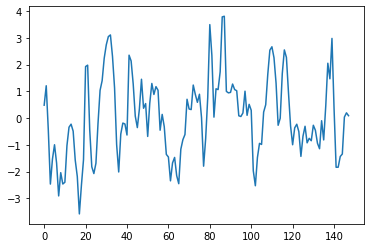

In [45]:
# make the data
n = 1000
eta = np.random.normal(0, 1, n)
rho = [0.85, -0.25]
y = eta.copy()
for i in range(2, n):
    y[i] = rho[0]*y[i-1] + rho[1]*y[i-2] + eta[i]

#plt.plot(y)
plt.plot(y[2:150])

In [46]:
data = {
    'N': len(y),
    'K': 3,
    'y': y,
}

In [47]:

model_code = """
    data {
      int<lower=0> K;
      int<lower=0> N;
      real y[N];
    }
    parameters {
      real<lower=-1,upper=1> rho[K];
      real sigma;
    }
    
    
    transformed parameters {
        vector[N] yhat;
        vector[N] log_p;
        for (i in (K+1):N) {
            yhat[i] = 0;
            for (k in 1:K)
              yhat[i] += rho[k] * y[i-k];
            log_p[i] = normal_lpdf(y[i]|yhat[i], sigma);
            }
    }
    
    
    model {
      
      for (i in (K+1):N) 
        y[i] ~ normal(yhat[i], sigma);
      
    }"""
AR_K = StanModel(model_code=model_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_803ebb3b05161220dab6fc73b7ece80b NOW.
In file included from /var/folders/2r/w1lk3nxj09s73plknkyzzj5m0000gn/T/pystan_nod6bwcs/stanfit4anon_model_803ebb3b05161220dab6fc73b7ece80b_2106773014397203382.cpp:709:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/numpy/core/include/numpy/arrayobject.h:4:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/numpy/core/include/numpy/ndarrayobject.h:12:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/numpy/core/include/numpy/ndarraytypes.h:1969:
/Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/numpy/core/include/numpy/npy_1_7_deprecated_api.h:17:2: warning: "Using deprecated NumPy API, disable it with "          "#define NPY_NO_DEPRECATED_API NPY_1_7_API_VERSION" [-W#warnings]
#warning "Using deprecated NumPy API, di

In file included from /var/folders/2r/w1lk3nxj09s73plknkyzzj5m0000gn/T/pystan_nod6bwcs/stanfit4anon_model_803ebb3b05161220dab6fc73b7ece80b_2106773014397203382.cpp:718:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/py_var_context.hpp:12:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/stan/src/stan/io/dump.hpp:6:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat.hpp:9:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat/meta/as_array_or_scalar.hpp:4:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Dense:1:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/pytho

In file included from /var/folders/2r/w1lk3nxj09s73plknkyzzj5m0000gn/T/pystan_nod6bwcs/stanfit4anon_model_803ebb3b05161220dab6fc73b7ece80b_2106773014397203382.cpp:718:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/py_var_context.hpp:12:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/stan/src/stan/io/dump.hpp:6:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat.hpp:9:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat/meta/as_array_or_scalar.hpp:4:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Dense:1:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/pytho

In file included from /var/folders/2r/w1lk3nxj09s73plknkyzzj5m0000gn/T/pystan_nod6bwcs/stanfit4anon_model_803ebb3b05161220dab6fc73b7ece80b_2106773014397203382.cpp:719:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/stan_fit.hpp:15:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/stan/lib/stan_math/lib/boost_1.69.0/boost/random/additive_combine.hpp:27:
/Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/stan/lib/stan_math/lib/boost_1.69.0/boost/random/linear_congruential.hpp:140:20: warning: overlapping comparisons always evaluate to false [-Wtautological-overlap-compare]
        if(_x <= 0 && _x != 0) {
           ~~~~~~~~^~~~~~~~~~
/Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/stan/lib/stan_math/lib/boost_1.69.0/boost/random/linear_congruential.hpp:393:11: note: in instantiation of member function

In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Core:420:
/Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/src/Core/AssignEvaluator.h:86:63: warning: converting the enum constant to a boolean [-Wint-in-bool-context]
    MayLinearVectorize = bool(MightVectorize) && MayLinearize && DstHasDirectAccess
                                                              ^
/Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/src/Core/AssignEvaluator.h:607:20: note: in instantiation of template class 'Eigen::internal::copy_using_evaluator_traits<Eigen::internal::evaluator<Eigen::Transpose<Eigen::Block<Eigen::Matrix<double, -1, -1, 0>, -1, -1, false>>>, Eigen::internal::evaluator<Eigen::Transpose<Eigen::Block<Eigen::Matrix<double, -1, -1, 0>, -1, -1, fal

In file included from /var/folders/2r/w1lk3nxj09s73plknkyzzj5m0000gn/T/pystan_nod6bwcs/stanfit4anon_model_803ebb3b05161220dab6fc73b7ece80b_2106773014397203382.cpp:718:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/py_var_context.hpp:12:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/stan/src/stan/io/dump.hpp:6:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat.hpp:9:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat/meta/as_array_or_scalar.hpp:4:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Dense:1:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/pytho

In file included from /var/folders/2r/w1lk3nxj09s73plknkyzzj5m0000gn/T/pystan_nod6bwcs/stanfit4anon_model_803ebb3b05161220dab6fc73b7ece80b_2106773014397203382.cpp:718:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/py_var_context.hpp:12:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/stan/src/stan/io/dump.hpp:6:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat.hpp:9:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat/meta/as_array_or_scalar.hpp:4:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Dense:1:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/pytho

In file included from /var/folders/2r/w1lk3nxj09s73plknkyzzj5m0000gn/T/pystan_nod6bwcs/stanfit4anon_model_803ebb3b05161220dab6fc73b7ece80b_2106773014397203382.cpp:718:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/py_var_context.hpp:12:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/stan/src/stan/io/dump.hpp:6:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat.hpp:9:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat/meta/as_array_or_scalar.hpp:4:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Dense:1:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/pytho

In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Core:420:
/Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/src/Core/AssignEvaluator.h:86:63: warning: converting the enum constant to a boolean [-Wint-in-bool-context]
    MayLinearVectorize = bool(MightVectorize) && MayLinearize && DstHasDirectAccess
                                                              ^
/Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/src/Core/AssignEvaluator.h:607:20: note: in instantiation of template class 'Eigen::internal::copy_using_evaluator_traits<Eigen::internal::evaluator<Eigen::Matrix<double, -1, -1, 0>>, Eigen::internal::evaluator<Eigen::Map<const Eigen::Matrix<double, -1, -1, 0>, 0>>, Eigen::internal::assign_op<double, double>>' requested here
  type

In file included from /var/folders/2r/w1lk3nxj09s73plknkyzzj5m0000gn/T/pystan_nod6bwcs/stanfit4anon_model_803ebb3b05161220dab6fc73b7ece80b_2106773014397203382.cpp:718:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/py_var_context.hpp:12:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/stan/src/stan/io/dump.hpp:6:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat.hpp:9:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat/meta/as_array_or_scalar.hpp:4:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Dense:1:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/pytho

In file included from /var/folders/2r/w1lk3nxj09s73plknkyzzj5m0000gn/T/pystan_nod6bwcs/stanfit4anon_model_803ebb3b05161220dab6fc73b7ece80b_2106773014397203382.cpp:718:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/py_var_context.hpp:12:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/stan/src/stan/io/dump.hpp:6:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat.hpp:9:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat/meta/as_array_or_scalar.hpp:4:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Dense:1:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/pytho

In file included from /var/folders/2r/w1lk3nxj09s73plknkyzzj5m0000gn/T/pystan_nod6bwcs/stanfit4anon_model_803ebb3b05161220dab6fc73b7ece80b_2106773014397203382.cpp:718:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/py_var_context.hpp:12:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/stan/src/stan/io/dump.hpp:6:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat.hpp:9:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat/meta/as_array_or_scalar.hpp:4:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Dense:1:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/pytho

In file included from /var/folders/2r/w1lk3nxj09s73plknkyzzj5m0000gn/T/pystan_nod6bwcs/stanfit4anon_model_803ebb3b05161220dab6fc73b7ece80b_2106773014397203382.cpp:718:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/py_var_context.hpp:12:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/stan/src/stan/io/dump.hpp:6:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat.hpp:9:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat/meta/as_array_or_scalar.hpp:4:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Dense:1:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/pytho

152 warnings generated.


In [48]:
WAIC_list = np.zeros((10))
lppd_list = np.zeros((10))
p_list = np.zeros((10))

for k in range(1, 11):
    data = {
    'N': len(y),
    'K': k,
    'y': y,
    }
    fit_AR_K = AR_K.sampling(data=data, iter=2000, chains=4, verbose =False)
    posteriors_AR_K = fit_AR_K.extract(permuted=True) 
    WAIC_v, lppd, P_WAIC2 = WAIC(log_p = posteriors_AR_K['log_p'])
    WAIC_list[k-1] = WAIC_v
    lppd_list[k-1] = lppd
    p_list[k-1] = P_WAIC2  
    
    print("-------------------------------------------------------------------------------")
    print(k)
    print(WAIC_v)
    print("-------------------------------------------------------------------------------")    
    


Gradient evaluation took 0.000441 seconds
1000 transitions using 10 leapfrog steps per transition would take 4.41 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.000551 seconds
1000 transitions using 10 leapfrog steps per transition would take 5.51 seconds.
Adjust your expectations accordingly!


Rejecting initial value:
  Error evaluating the log probability at the initial value.
Exception: normal_lpdf: Scale parameter is -1.17311, but must be > 0!  (in 'unknown file name' at line 20)


Gradient evaluation took 0.000421 seconds
1000 transitions using 10 leapfrog steps per transition would take 4.21 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.000406 seconds
1000 transitions using 10 leapfrog steps per transition would take 4.06 seconds.
Adjust your expectations accordingly!


Iteration:    1 / 2000 [  0%]  (Warmup)
Iteration:    1 / 2000 [  0%]  (Warmup)
Iteration:    1 / 2000 [  0%]  (Warmup)
Iteration:    1 / 2000 [  0%] 

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: normal_lpdf: Scale parameter is -8233.13, but must be > 0!  (in 'unknown file name' at line 20)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: normal_lpdf: Scale parameter is -20322, but must be > 0!  (in 'unknown file name' at line 20)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
Informational Message: The current Metropolis proposal is about to be rejected beca

Iteration:  200 / 2000 [ 10%]  (Warmup)
Iteration:  200 / 2000 [ 10%]  (Warmup)
Iteration:  200 / 2000 [ 10%]  (Warmup)
Iteration:  200 / 2000 [ 10%]  (Warmup)
Iteration:  400 / 2000 [ 20%]  (Warmup)
Iteration:  400 / 2000 [ 20%]  (Warmup)
Iteration:  400 / 2000 [ 20%]  (Warmup)
Iteration:  400 / 2000 [ 20%]  (Warmup)


Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: normal_lpdf: Scale parameter is -7.06147, but must be > 0!  (in 'unknown file name' at line 20)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: normal_lpdf: Scale parameter is -1.42556, but must be > 0!  (in 'unknown file name' at line 20)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.



Iteration:  600 / 2000 [ 30%]  (Warmup)
Iteration:  600 / 2000 [ 30%]  (Warmup)
Iteration:  600 / 2000 [ 30%]  (Warmup)
Iteration:  600 / 2000 [ 30%]  (Warmup)
Iteration:  800 / 2000 [ 40%]  (Warmup)
Iteration:  800 / 2000 [ 40%]  (Warmup)
Iteration:  800 / 2000 [ 40%]  (Warmup)
Iteration:  800 / 2000 [ 40%]  (Warmup)


Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: normal_lpdf: Scale parameter is -6.44937, but must be > 0!  (in 'unknown file name' at line 20)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.



Iteration: 1000 / 2000 [ 50%]  (Warmup)
Iteration: 1001 / 2000 [ 50%]  (Sampling)
Iteration: 1000 / 2000 [ 50%]  (Warmup)
Iteration: 1001 / 2000 [ 50%]  (Sampling)
Iteration: 1000 / 2000 [ 50%]  (Warmup)
Iteration: 1001 / 2000 [ 50%]  (Sampling)
Iteration: 1000 / 2000 [ 50%]  (Warmup)
Iteration: 1001 / 2000 [ 50%]  (Sampling)
Iteration: 1200 / 2000 [ 60%]  (Sampling)
Iteration: 1200 / 2000 [ 60%]  (Sampling)
Iteration: 1200 / 2000 [ 60%]  (Sampling)
Iteration: 1200 / 2000 [ 60%]  (Sampling)
Iteration: 1400 / 2000 [ 70%]  (Sampling)
Iteration: 1400 / 2000 [ 70%]  (Sampling)
Iteration: 1400 / 2000 [ 70%]  (Sampling)
Iteration: 1400 / 2000 [ 70%]  (Sampling)
Iteration: 1600 / 2000 [ 80%]  (Sampling)
Iteration: 1600 / 2000 [ 80%]  (Sampling)
Iteration: 1600 / 2000 [ 80%]  (Sampling)
Iteration: 1800 / 2000 [ 90%]  (Sampling)
Iteration: 1600 / 2000 [ 80%]  (Sampling)
Iteration: 1800 / 2000 [ 90%]  (Sampling)
Iteration: 1800 / 2000 [ 90%]  (Sampling)
Iteration: 2000 / 2000 [100%]  (Sampling)


To run all diagnostics call pystan.check_hmc_diagnostics(fit)


-------------------------------------------------------------------------------
1
2869.16746351049
-------------------------------------------------------------------------------

Gradient evaluation took 0.000916 seconds
1000 transitions using 10 leapfrog steps per transition would take 9.16 seconds.
Adjust your expectations accordingly!


Rejecting initial value:
  Error evaluating the log probability at the initial value.
Exception: normal_lpdf: Scale parameter is -1.7902, but must be > 0!  (in 'unknown file name' at line 20)


Gradient evaluation took 0.00051 seconds
1000 transitions using 10 leapfrog steps per transition would take 5.1 seconds.
Adjust your expectations accordingly!


Rejecting initial value:
  Error evaluating the log probability at the initial value.
Exception: normal_lpdf: Scale parameter is -0.00422724, but must be > 0!  (in 'unknown file name' at line 20)

Rejecting initial value:
  Error evaluating the log probability at the initial value.
Exception: normal_l

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: normal_lpdf: Scale parameter is -22958.3, but must be > 0!  (in 'unknown file name' at line 20)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: normal_lpdf: Scale parameter is -657.629, but must be > 0!  (in 'unknown file name' at line 20)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected b

Iteration:  200 / 2000 [ 10%]  (Warmup)
Iteration:  200 / 2000 [ 10%]  (Warmup)
Iteration:  200 / 2000 [ 10%]  (Warmup)
Iteration:  200 / 2000 [ 10%]  (Warmup)
Iteration:  400 / 2000 [ 20%]  (Warmup)
Iteration:  400 / 2000 [ 20%]  (Warmup)
Iteration:  400 / 2000 [ 20%]  (Warmup)
Iteration:  400 / 2000 [ 20%]  (Warmup)
Iteration:  600 / 2000 [ 30%]  (Warmup)
Iteration:  600 / 2000 [ 30%]  (Warmup)
Iteration:  600 / 2000 [ 30%]  (Warmup)
Iteration:  600 / 2000 [ 30%]  (Warmup)
Iteration:  800 / 2000 [ 40%]  (Warmup)
Iteration:  800 / 2000 [ 40%]  (Warmup)
Iteration:  800 / 2000 [ 40%]  (Warmup)
Iteration:  800 / 2000 [ 40%]  (Warmup)
Iteration: 1000 / 2000 [ 50%]  (Warmup)
Iteration: 1001 / 2000 [ 50%]  (Sampling)
Iteration: 1000 / 2000 [ 50%]  (Warmup)
Iteration: 1001 / 2000 [ 50%]  (Sampling)
Iteration: 1000 / 2000 [ 50%]  (Warmup)
Iteration: 1001 / 2000 [ 50%]  (Sampling)
Iteration: 1000 / 2000 [ 50%]  (Warmup)
Iteration: 1001 / 2000 [ 50%]  (Sampling)
Iteration: 1200 / 2000 [ 60%]  (

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


-------------------------------------------------------------------------------
2
2790.733242998328
-------------------------------------------------------------------------------

Gradient evaluation took 0.000808 seconds
1000 transitions using 10 leapfrog steps per transition would take 8.08 seconds.
Adjust your expectations accordingly!


Rejecting initial value:
  Error evaluating the log probability at the initial value.
Exception: normal_lpdf: Scale parameter is -0.30147, but must be > 0!  (in 'unknown file name' at line 20)

Rejecting initial value:
  Error evaluating the log probability at the initial value.
Exception: normal_lpdf: Scale parameter is -0.65397, but must be > 0!  (in 'unknown file name' at line 20)

Rejecting initial value:
  Error evaluating the log probability at the initial value.
Exception: normal_lpdf: Scale parameter is -1.22547, but must be > 0!  (in 'unknown file name' at line 20)

Rejecting initial value:
  Error evaluating the log probability at the ini

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: normal_lpdf: Scale parameter is -15766.3, but must be > 0!  (in 'unknown file name' at line 20)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: normal_lpdf: Scale parameter is -447.016, but must be > 0!  (in 'unknown file name' at line 20)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected b

Iteration:  200 / 2000 [ 10%]  (Warmup)
Iteration:  200 / 2000 [ 10%]  (Warmup)
Iteration:  200 / 2000 [ 10%]  (Warmup)
Iteration:  200 / 2000 [ 10%]  (Warmup)
Iteration:  400 / 2000 [ 20%]  (Warmup)
Iteration:  400 / 2000 [ 20%]  (Warmup)
Iteration:  400 / 2000 [ 20%]  (Warmup)
Iteration:  400 / 2000 [ 20%]  (Warmup)
Iteration:  600 / 2000 [ 30%]  (Warmup)
Iteration:  600 / 2000 [ 30%]  (Warmup)
Iteration:  600 / 2000 [ 30%]  (Warmup)
Iteration:  600 / 2000 [ 30%]  (Warmup)
Iteration:  800 / 2000 [ 40%]  (Warmup)
Iteration:  800 / 2000 [ 40%]  (Warmup)
Iteration:  800 / 2000 [ 40%]  (Warmup)
Iteration:  800 / 2000 [ 40%]  (Warmup)
Iteration: 1000 / 2000 [ 50%]  (Warmup)
Iteration: 1001 / 2000 [ 50%]  (Sampling)
Iteration: 1000 / 2000 [ 50%]  (Warmup)
Iteration: 1001 / 2000 [ 50%]  (Sampling)
Iteration: 1000 / 2000 [ 50%]  (Warmup)
Iteration: 1001 / 2000 [ 50%]  (Sampling)
Iteration: 1000 / 2000 [ 50%]  (Warmup)
Iteration: 1001 / 2000 [ 50%]  (Sampling)
Iteration: 1200 / 2000 [ 60%]  (

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


-------------------------------------------------------------------------------
3
2788.370599551821
-------------------------------------------------------------------------------
Rejecting initial value:
  Error evaluating the log probability at the initial value.
Exception: normal_lpdf: Scale parameter is -0.667598, but must be > 0!  (in 'unknown file name' at line 20)

Rejecting initial value:
  Error evaluating the log probability at the initial value.
Exception: normal_lpdf: Scale parameter is -0.947452, but must be > 0!  (in 'unknown file name' at line 20)

Rejecting initial value:
  Error evaluating the log probability at the initial value.
Exception: normal_lpdf: Scale parameter is -1.24515, but must be > 0!  (in 'unknown file name' at line 20)


Gradient evaluation took 0.000685 seconds
1000 transitions using 10 leapfrog steps per transition would take 6.85 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.001241 seconds
1000 transitions using 10 lea

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: normal_lpdf: Scale parameter is -29.8892, but must be > 0!  (in 'unknown file name' at line 20)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: normal_lpdf: Scale parameter is -30.9971, but must be > 0!  (in 'unknown file name' at line 20)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected b

Iteration:  200 / 2000 [ 10%]  (Warmup)
Iteration:  200 / 2000 [ 10%]  (Warmup)
Iteration:  200 / 2000 [ 10%]  (Warmup)
Iteration:  200 / 2000 [ 10%]  (Warmup)
Iteration:  400 / 2000 [ 20%]  (Warmup)
Iteration:  400 / 2000 [ 20%]  (Warmup)
Iteration:  400 / 2000 [ 20%]  (Warmup)
Iteration:  400 / 2000 [ 20%]  (Warmup)
Iteration:  600 / 2000 [ 30%]  (Warmup)
Iteration:  600 / 2000 [ 30%]  (Warmup)
Iteration:  600 / 2000 [ 30%]  (Warmup)
Iteration:  600 / 2000 [ 30%]  (Warmup)
Iteration:  800 / 2000 [ 40%]  (Warmup)
Iteration:  800 / 2000 [ 40%]  (Warmup)
Iteration:  800 / 2000 [ 40%]  (Warmup)
Iteration:  800 / 2000 [ 40%]  (Warmup)
Iteration: 1000 / 2000 [ 50%]  (Warmup)
Iteration: 1001 / 2000 [ 50%]  (Sampling)
Iteration: 1000 / 2000 [ 50%]  (Warmup)
Iteration: 1001 / 2000 [ 50%]  (Sampling)
Iteration: 1000 / 2000 [ 50%]  (Warmup)
Iteration: 1001 / 2000 [ 50%]  (Sampling)
Iteration: 1000 / 2000 [ 50%]  (Warmup)
Iteration: 1001 / 2000 [ 50%]  (Sampling)
Iteration: 1200 / 2000 [ 60%]  (

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


-------------------------------------------------------------------------------
4
2788.1015523873316
-------------------------------------------------------------------------------
Rejecting initial value:
  Error evaluating the log probability at the initial value.
Exception: normal_lpdf: Scale parameter is -1.28054, but must be > 0!  (in 'unknown file name' at line 20)


Gradient evaluation took 0.001148 seconds
1000 transitions using 10 leapfrog steps per transition would take 11.48 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.001337 seconds
1000 transitions using 10 leapfrog steps per transition would take 13.37 seconds.
Adjust your expectations accordingly!


Rejecting initial value:
  Error evaluating the log probability at the initial value.
Exception: normal_lpdf: Scale parameter is -1.7657, but must be > 0!  (in 'unknown file name' at line 20)


Gradient evaluation took 0.000999 seconds
1000 transitions using 10 leapfrog steps per transition wou

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: normal_lpdf: Scale parameter is -101.193, but must be > 0!  (in 'unknown file name' at line 20)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: normal_lpdf: Scale parameter is -101.826, but must be > 0!  (in 'unknown file name' at line 20)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected b

Iteration:  200 / 2000 [ 10%]  (Warmup)
Iteration:  200 / 2000 [ 10%]  (Warmup)
Iteration:  200 / 2000 [ 10%]  (Warmup)
Iteration:  200 / 2000 [ 10%]  (Warmup)
Iteration:  400 / 2000 [ 20%]  (Warmup)
Iteration:  400 / 2000 [ 20%]  (Warmup)
Iteration:  400 / 2000 [ 20%]  (Warmup)
Iteration:  400 / 2000 [ 20%]  (Warmup)


Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: normal_lpdf: Scale parameter is -0.0144852, but must be > 0!  (in 'unknown file name' at line 20)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.



Iteration:  600 / 2000 [ 30%]  (Warmup)
Iteration:  600 / 2000 [ 30%]  (Warmup)
Iteration:  600 / 2000 [ 30%]  (Warmup)
Iteration:  600 / 2000 [ 30%]  (Warmup)
Iteration:  800 / 2000 [ 40%]  (Warmup)
Iteration:  800 / 2000 [ 40%]  (Warmup)
Iteration:  800 / 2000 [ 40%]  (Warmup)
Iteration:  800 / 2000 [ 40%]  (Warmup)
Iteration: 1000 / 2000 [ 50%]  (Warmup)
Iteration: 1001 / 2000 [ 50%]  (Sampling)
Iteration: 1000 / 2000 [ 50%]  (Warmup)
Iteration: 1001 / 2000 [ 50%]  (Sampling)
Iteration: 1000 / 2000 [ 50%]  (Warmup)
Iteration: 1001 / 2000 [ 50%]  (Sampling)
Iteration: 1000 / 2000 [ 50%]  (Warmup)
Iteration: 1001 / 2000 [ 50%]  (Sampling)
Iteration: 1200 / 2000 [ 60%]  (Sampling)
Iteration: 1200 / 2000 [ 60%]  (Sampling)
Iteration: 1200 / 2000 [ 60%]  (Sampling)
Iteration: 1200 / 2000 [ 60%]  (Sampling)
Iteration: 1400 / 2000 [ 70%]  (Sampling)
Iteration: 1400 / 2000 [ 70%]  (Sampling)
Iteration: 1400 / 2000 [ 70%]  (Sampling)
Iteration: 1400 / 2000 [ 70%]  (Sampling)
Iteration: 1600 

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


-------------------------------------------------------------------------------
5
2784.305767085217
-------------------------------------------------------------------------------

Gradient evaluation took 0.001024 seconds
1000 transitions using 10 leapfrog steps per transition would take 10.24 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.000916 seconds
1000 transitions using 10 leapfrog steps per transition would take 9.16 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.000942 seconds

1000 transitions using 10 leapfrog steps per transition would take 9.42 seconds.
Adjust your expectations accordingly!


Gradient evaluation took 0.000948 seconds
1000 transitions using 10 leapfrog steps per transition would take 9.48 seconds.
Adjust your expectations accordingly!


Iteration:    1 / 2000 [  0%]  (Warmup)
Iteration:    1 / 2000 [  0%]  (Warmup)
Iteration:    1 / 2000 [  0%]  (Warmup)
Iteration:    1 / 2000 [  0%]  (Warmup)


Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: normal_lpdf: Scale parameter is -2764.4, but must be > 0!  (in 'unknown file name' at line 20)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: normal_lpdf: Scale parameter is -54.5517, but must be > 0!  (in 'unknown file name' at line 20)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected be

Iteration:  200 / 2000 [ 10%]  (Warmup)
Iteration:  200 / 2000 [ 10%]  (Warmup)
Iteration:  200 / 2000 [ 10%]  (Warmup)
Iteration:  200 / 2000 [ 10%]  (Warmup)
Iteration:  400 / 2000 [ 20%]  (Warmup)
Iteration:  400 / 2000 [ 20%]  (Warmup)
Iteration:  400 / 2000 [ 20%]  (Warmup)
Iteration:  400 / 2000 [ 20%]  (Warmup)
Iteration:  600 / 2000 [ 30%]  (Warmup)
Iteration:  600 / 2000 [ 30%]  (Warmup)
Iteration:  600 / 2000 [ 30%]  (Warmup)
Iteration:  600 / 2000 [ 30%]  (Warmup)
Iteration:  800 / 2000 [ 40%]  (Warmup)
Iteration:  800 / 2000 [ 40%]  (Warmup)
Iteration:  800 / 2000 [ 40%]  (Warmup)
Iteration:  800 / 2000 [ 40%]  (Warmup)
Iteration: 1000 / 2000 [ 50%]  (Warmup)
Iteration: 1001 / 2000 [ 50%]  (Sampling)
Iteration: 1000 / 2000 [ 50%]  (Warmup)
Iteration: 1001 / 2000 [ 50%]  (Sampling)
Iteration: 1000 / 2000 [ 50%]  (Warmup)
Iteration: 1001 / 2000 [ 50%]  (Sampling)
Iteration: 1000 / 2000 [ 50%]  (Warmup)
Iteration: 1001 / 2000 [ 50%]  (Sampling)
Iteration: 1200 / 2000 [ 60%]  (

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


-------------------------------------------------------------------------------
6
2780.3698816457663
-------------------------------------------------------------------------------
Rejecting initial value:
  Error evaluating the log probability at the initial value.
Exception: normal_lpdf: Scale parameter is -1.76785, but must be > 0!  (in 'unknown file name' at line 20)


Gradient evaluation took 0.001298 seconds
1000 transitions using 10 leapfrog steps per transition would take 12.98 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.001357 seconds
1000 transitions using 10 leapfrog steps per transition would take 13.57 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.001422 seconds
1000 transitions using 10 leapfrog steps per transition would take 14.22 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.001194 seconds
1000 transitions using 10 leapfrog steps per transition would take 11.94 seconds.
Adjus

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


-------------------------------------------------------------------------------
7
2780.5497687189622
-------------------------------------------------------------------------------

Gradient evaluation took 0.001979 seconds
1000 transitions using 10 leapfrog steps per transition would take 19.79 seconds.
Adjust your expectations accordingly!


Rejecting initial value:
  Error evaluating the log probability at the initial value.
Exception: normal_lpdf: Scale parameter is -0.527527, but must be > 0!  (in 'unknown file name' at line 20)


Gradient evaluation took 0.001757 seconds
1000 transitions using 10 leapfrog steps per transition would take 17.57 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.001159 seconds
1000 transitions using 10 leapfrog steps per transition would take 11.59 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.00121 seconds
1000 transitions using 10 leapfrog steps per transition would take 12.1 seconds.
Adjust

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: normal_lpdf: Scale parameter is -0.059285, but must be > 0!  (in 'unknown file name' at line 20)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: normal_lpdf: Scale parameter is -0.0677248, but must be > 0!  (in 'unknown file name' at line 20)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.



Iteration:  200 / 2000 [ 10%]  (Warmup)
Iteration:  200 / 2000 [ 10%]  (Warmup)
Iteration:  200 / 2000 [ 10%]  (Warmup)
Iteration:  200 / 2000 [ 10%]  (Warmup)
Iteration:  400 / 2000 [ 20%]  (Warmup)
Iteration:  400 / 2000 [ 20%]  (Warmup)
Iteration:  400 / 2000 [ 20%]  (Warmup)
Iteration:  400 / 2000 [ 20%]  (Warmup)
Iteration:  600 / 2000 [ 30%]  (Warmup)
Iteration:  600 / 2000 [ 30%]  (Warmup)
Iteration:  600 / 2000 [ 30%]  (Warmup)
Iteration:  600 / 2000 [ 30%]  (Warmup)
Iteration:  800 / 2000 [ 40%]  (Warmup)
Iteration:  800 / 2000 [ 40%]  (Warmup)
Iteration:  800 / 2000 [ 40%]  (Warmup)
Iteration:  800 / 2000 [ 40%]  (Warmup)
Iteration: 1000 / 2000 [ 50%]  (Warmup)
Iteration: 1001 / 2000 [ 50%]  (Sampling)
Iteration: 1000 / 2000 [ 50%]  (Warmup)
Iteration: 1001 / 2000 [ 50%]  (Sampling)
Iteration: 1000 / 2000 [ 50%]  (Warmup)
Iteration: 1001 / 2000 [ 50%]  (Sampling)
Iteration: 1000 / 2000 [ 50%]  (Warmup)
Iteration: 1001 / 2000 [ 50%]  (Sampling)
Iteration: 1200 / 2000 [ 60%]  (

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


-------------------------------------------------------------------------------
8
2780.2824121572557
-------------------------------------------------------------------------------
Rejecting initial value:
  Error evaluating the log probability at the initial value.
Exception: normal_lpdf: Scale parameter is -0.856222, but must be > 0!  (in 'unknown file name' at line 20)

Rejecting initial value:
  Error evaluating the log probability at the initial value.
Exception: normal_lpdf: Scale parameter is -1.92635, but must be > 0!  (in 'unknown file name' at line 20)

Rejecting initial value:
  Error evaluating the log probability at the initial value.
Exception: normal_lpdf: Scale parameter is -1.03169, but must be > 0!  (in 'unknown file name' at line 20)


Gradient evaluation took 0.00141 seconds
1000 transitions using 10 leapfrog steps per transition would take 14.1 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.001368 seconds
1000 transitions using 10 leap

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: normal_lpdf: Scale parameter is -0.479739, but must be > 0!  (in 'unknown file name' at line 20)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: normal_lpdf: Scale parameter is -1.89812, but must be > 0!  (in 'unknown file name' at line 20)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.



Iteration:  200 / 2000 [ 10%]  (Warmup)
Iteration:  200 / 2000 [ 10%]  (Warmup)
Iteration:  200 / 2000 [ 10%]  (Warmup)
Iteration:  200 / 2000 [ 10%]  (Warmup)
Iteration:  400 / 2000 [ 20%]  (Warmup)
Iteration:  400 / 2000 [ 20%]  (Warmup)
Iteration:  400 / 2000 [ 20%]  (Warmup)
Iteration:  400 / 2000 [ 20%]  (Warmup)
Iteration:  600 / 2000 [ 30%]  (Warmup)
Iteration:  600 / 2000 [ 30%]  (Warmup)
Iteration:  600 / 2000 [ 30%]  (Warmup)
Iteration:  600 / 2000 [ 30%]  (Warmup)
Iteration:  800 / 2000 [ 40%]  (Warmup)
Iteration:  800 / 2000 [ 40%]  (Warmup)
Iteration:  800 / 2000 [ 40%]  (Warmup)
Iteration:  800 / 2000 [ 40%]  (Warmup)
Iteration: 1000 / 2000 [ 50%]  (Warmup)
Iteration: 1001 / 2000 [ 50%]  (Sampling)
Iteration: 1000 / 2000 [ 50%]  (Warmup)
Iteration: 1001 / 2000 [ 50%]  (Sampling)
Iteration: 1000 / 2000 [ 50%]  (Warmup)
Iteration: 1001 / 2000 [ 50%]  (Sampling)
Iteration: 1000 / 2000 [ 50%]  (Warmup)
Iteration: 1001 / 2000 [ 50%]  (Sampling)
Iteration: 1200 / 2000 [ 60%]  (

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


-------------------------------------------------------------------------------
9
2778.522786724629
-------------------------------------------------------------------------------
Rejecting initial value:
  Error evaluating the log probability at the initial value.
Exception: normal_lpdf: Scale parameter is -1.78749, but must be > 0!  (in 'unknown file name' at line 20)

Rejecting initial value:
  Error evaluating the log probability at the initial value.
Exception: normal_lpdf: Scale parameter is -1.62689, but must be > 0!  (in 'unknown file name' at line 20)


Gradient evaluation took 0.001354 seconds
1000 transitions using 10 leapfrog steps per transition would take 13.54 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.001293 seconds
1000 transitions using 10 leapfrog steps per transition would take 12.93 seconds.
Adjust your expectations accordingly!


Rejecting initial value:
  Error evaluating the log probability at the initial value.
Exception: norma

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: normal_lpdf: Scale parameter is -1227.45, but must be > 0!  (in 'unknown file name' at line 20)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: normal_lpdf: Scale parameter is -19.3279, but must be > 0!  (in 'unknown file name' at line 20)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected b

Iteration:  200 / 2000 [ 10%]  (Warmup)
Iteration:  200 / 2000 [ 10%]  (Warmup)
Iteration:  200 / 2000 [ 10%]  (Warmup)
Iteration:  200 / 2000 [ 10%]  (Warmup)
Iteration:  400 / 2000 [ 20%]  (Warmup)
Iteration:  400 / 2000 [ 20%]  (Warmup)
Iteration:  400 / 2000 [ 20%]  (Warmup)
Iteration:  400 / 2000 [ 20%]  (Warmup)
Iteration:  600 / 2000 [ 30%]  (Warmup)
Iteration:  600 / 2000 [ 30%]  (Warmup)
Iteration:  600 / 2000 [ 30%]  (Warmup)
Iteration:  600 / 2000 [ 30%]  (Warmup)
Iteration:  800 / 2000 [ 40%]  (Warmup)
Iteration:  800 / 2000 [ 40%]  (Warmup)
Iteration:  800 / 2000 [ 40%]  (Warmup)
Iteration:  800 / 2000 [ 40%]  (Warmup)
Iteration: 1000 / 2000 [ 50%]  (Warmup)
Iteration: 1001 / 2000 [ 50%]  (Sampling)
Iteration: 1000 / 2000 [ 50%]  (Warmup)
Iteration: 1001 / 2000 [ 50%]  (Sampling)
Iteration: 1000 / 2000 [ 50%]  (Warmup)
Iteration: 1001 / 2000 [ 50%]  (Sampling)
Iteration: 1000 / 2000 [ 50%]  (Warmup)
Iteration: 1001 / 2000 [ 50%]  (Sampling)
Iteration: 1200 / 2000 [ 60%]  (

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


-------------------------------------------------------------------------------
10
2775.309129458911
-------------------------------------------------------------------------------


In [49]:
print(WAIC_list)
print( lppd_list)
print( p_list)


[2869.16746351 2790.733243   2788.37059955 2788.10155239 2784.30576709
 2780.36988165 2780.54976872 2780.28241216 2778.52278672 2775.30912946]
[-1432.44178464 -1392.43242398 -1390.17155787 -1389.09480671
 -1385.9097761  -1383.29389984 -1382.18153486 -1381.09261586
 -1379.11572016 -1376.35279244]
[ 2.14194711  2.93419752  4.0137419   4.95596948  6.24310745  6.89104098
  8.0933495   9.04859022 10.1456732  11.30177229]



This does not seem to work because there is too much data and the AR lag parameters are too efficient
 

In [50]:
WAIC_list = np.zeros((10))
lppd_list = np.zeros((10))
p_list = np.zeros((10))

for k in range(1, 11):
    data = {
    'N': len(y),
    'K': k,
    'y': y,
    }
    fit_AR_K = AR_K.sampling(data=data, iter=2000, chains=4, verbose =False)
    posteriors_AR_K = fit_AR_K.extract(permuted=True) 
    ####################################################################################
    WAIC_v, lppd, P_WAIC2 = WAIC(log_p = posteriors_AR_K['log_p'], k = np.log(n-10)) # this line was updated
    # log 990 is number of data points shared by all models. THis is similar to the BIC.
    ####################################################################################    
    WAIC_list[k-1] = WAIC_v
    lppd_list[k-1] = lppd
    p_list[k-1] = P_WAIC2  
    
    print("-------------------------------------------------------------------------------")
    print(k)
    print(WAIC_v)
    print("-------------------------------------------------------------------------------")    
    

Rejecting initial value:
  Error evaluating the log probability at the initial value.
Exception: normal_lpdf: Scale parameter is -0.65741, but must be > 0!  (in 'unknown file name' at line 20)


Gradient evaluation took 0.000366 seconds
1000 transitions using 10 leapfrog steps per transition would take 3.66 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.000397 seconds
1000 transitions using 10 leapfrog steps per transition would take 3.97 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.001798 seconds
1000 transitions using 10 leapfrog steps per transition would take 17.98 seconds.
Adjust your expectations accordingly!


Rejecting initial value:
  Error evaluating the log probability at the initial value.
Exception: normal_lpdf: Scale parameter is -0.547201, but must be > 0!  (in 'unknown file name' at line 20)


Gradient evaluation took 0.000325 seconds
1000 transitions using 10 leapfrog steps per transition would take 3.25 sec

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: normal_lpdf: Scale parameter is -1943.86, but must be > 0!  (in 'unknown file name' at line 20)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: normal_lpdf: Scale parameter is -41.6833, but must be > 0!  (in 'unknown file name' at line 20)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected b

Iteration:  400 / 2000 [ 20%]  (Warmup)
Iteration:  400 / 2000 [ 20%]  (Warmup)
Iteration:  400 / 2000 [ 20%]  (Warmup)
Iteration:  400 / 2000 [ 20%]  (Warmup)


Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: normal_lpdf: Scale parameter is -11.8761, but must be > 0!  (in 'unknown file name' at line 20)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.



Iteration:  600 / 2000 [ 30%]  (Warmup)
Iteration:  600 / 2000 [ 30%]  (Warmup)
Iteration:  600 / 2000 [ 30%]  (Warmup)
Iteration:  600 / 2000 [ 30%]  (Warmup)
Iteration:  800 / 2000 [ 40%]  (Warmup)
Iteration:  800 / 2000 [ 40%]  (Warmup)
Iteration:  800 / 2000 [ 40%]  (Warmup)
Iteration:  800 / 2000 [ 40%]  (Warmup)
Iteration: 1000 / 2000 [ 50%]  (Warmup)
Iteration: 1001 / 2000 [ 50%]  (Sampling)
Iteration: 1000 / 2000 [ 50%]  (Warmup)
Iteration: 1001 / 2000 [ 50%]  (Sampling)
Iteration: 1000 / 2000 [ 50%]  (Warmup)
Iteration: 1001 / 2000 [ 50%]  (Sampling)
Iteration: 1000 / 2000 [ 50%]  (Warmup)
Iteration: 1001 / 2000 [ 50%]  (Sampling)
Iteration: 1200 / 2000 [ 60%]  (Sampling)
Iteration: 1200 / 2000 [ 60%]  (Sampling)
Iteration: 1200 / 2000 [ 60%]  (Sampling)
Iteration: 1200 / 2000 [ 60%]  (Sampling)


Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: normal_lpdf: Scale parameter is -0.484527, but must be > 0!  (in 'unknown file name' at line 20)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.



Iteration: 1400 / 2000 [ 70%]  (Sampling)
Iteration: 1400 / 2000 [ 70%]  (Sampling)
Iteration: 1400 / 2000 [ 70%]  (Sampling)
Iteration: 1400 / 2000 [ 70%]  (Sampling)
Iteration: 1600 / 2000 [ 80%]  (Sampling)
Iteration: 1600 / 2000 [ 80%]  (Sampling)
Iteration: 1600 / 2000 [ 80%]  (Sampling)
Iteration: 1800 / 2000 [ 90%]  (Sampling)
Iteration: 1600 / 2000 [ 80%]  (Sampling)
Iteration: 2000 / 2000 [100%]  (Sampling)

 Elapsed Time: 0.575408 seconds (Warm-up)
               0.505806 seconds (Sampling)
               1.08121 seconds (Total)

Iteration: 1800 / 2000 [ 90%]  (Sampling)
Iteration: 1800 / 2000 [ 90%]  (Sampling)
Iteration: 1800 / 2000 [ 90%]  (Sampling)
Iteration: 2000 / 2000 [100%]  (Sampling)

 Elapsed Time: 0.614491 seconds (Warm-up)
               0.595355 seconds (Sampling)
               1.20985 seconds (Total)

Iteration: 2000 / 2000 [100%]  (Sampling)

 Elapsed Time: 0.642538 seconds (Warm-up)
               0.568944 seconds (Sampling)
               1.21148 seconds (

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


-------------------------------------------------------------------------------
1
2879.463913076265
-------------------------------------------------------------------------------

Gradient evaluation took 0.000754 seconds
1000 transitions using 10 leapfrog steps per transition would take 7.54 seconds.
Adjust your expectations accordingly!


Rejecting initial value:
  Error evaluating the log probability at the initial value.
Exception: normal_lpdf: Scale parameter is -1.40093, but must be > 0!  (in 'unknown file name' at line 20)


Gradient evaluation took 0.000471 seconds
1000 transitions using 10 leapfrog steps per transition would take 4.71 seconds.
Adjust your expectations accordingly!


Rejecting initial value:
  Error evaluating the log probability at the initial value.
Exception: normal_lpdf: Scale parameter is -0.953217, but must be > 0!  (in 'unknown file name' at line 20)


Gradient evaluation took 0.000453 seconds
1000 transitions using 10 leapfrog steps per transition woul

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: normal_lpdf: Scale parameter is -9.22286, but must be > 0!  (in 'unknown file name' at line 20)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: normal_lpdf: Scale parameter is -9.114, but must be > 0!  (in 'unknown file name' at line 20)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected bec

Iteration:  200 / 2000 [ 10%]  (Warmup)
Iteration:  200 / 2000 [ 10%]  (Warmup)
Iteration:  200 / 2000 [ 10%]  (Warmup)
Iteration:  200 / 2000 [ 10%]  (Warmup)
Iteration:  400 / 2000 [ 20%]  (Warmup)
Iteration:  400 / 2000 [ 20%]  (Warmup)
Iteration:  400 / 2000 [ 20%]  (Warmup)
Iteration:  400 / 2000 [ 20%]  (Warmup)
Iteration:  600 / 2000 [ 30%]  (Warmup)
Iteration:  600 / 2000 [ 30%]  (Warmup)
Iteration:  600 / 2000 [ 30%]  (Warmup)
Iteration:  600 / 2000 [ 30%]  (Warmup)
Iteration:  800 / 2000 [ 40%]  (Warmup)
Iteration:  800 / 2000 [ 40%]  (Warmup)
Iteration:  800 / 2000 [ 40%]  (Warmup)
Iteration:  800 / 2000 [ 40%]  (Warmup)
Iteration: 1000 / 2000 [ 50%]  (Warmup)
Iteration: 1001 / 2000 [ 50%]  (Sampling)
Iteration: 1000 / 2000 [ 50%]  (Warmup)
Iteration: 1001 / 2000 [ 50%]  (Sampling)
Iteration: 1000 / 2000 [ 50%]  (Warmup)
Iteration: 1001 / 2000 [ 50%]  (Sampling)
Iteration: 1000 / 2000 [ 50%]  (Warmup)
Iteration: 1001 / 2000 [ 50%]  (Sampling)
Iteration: 1200 / 2000 [ 60%]  (

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


-------------------------------------------------------------------------------
2
2805.037096783361
-------------------------------------------------------------------------------

Gradient evaluation took 0.00094 seconds
1000 transitions using 10 leapfrog steps per transition would take 9.4 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.000619 seconds
1000 transitions using 10 leapfrog steps per transition would take 6.19 seconds.
Adjust your expectations accordingly!


Rejecting initial value:
  Error evaluating the log probability at the initial value.
Rejecting initial value:
Exception: normal_lpdf: Scale parameter is -0.805336, but must be > 0!  (in 'unknown file name' at line 20)

  Error evaluating the log probability at the initial value.
Exception: normal_lpdf: Scale parameter is -0.596743, but must be > 0!  (in 'unknown file name' at line 20)

Rejecting initial value:
Rejecting initial value:
  Error evaluating the log probability at the initial 

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: normal_lpdf: Scale parameter is -5124.95, but must be > 0!  (in 'unknown file name' at line 20)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: normal_lpdf: Scale parameter is -83.1062, but must be > 0!  (in 'unknown file name' at line 20)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.



Iteration:  200 / 2000 [ 10%]  (Warmup)
Iteration:  200 / 2000 [ 10%]  (Warmup)
Iteration:  200 / 2000 [ 10%]  (Warmup)
Iteration:  200 / 2000 [ 10%]  (Warmup)
Iteration:  400 / 2000 [ 20%]  (Warmup)
Iteration:  400 / 2000 [ 20%]  (Warmup)
Iteration:  400 / 2000 [ 20%]  (Warmup)
Iteration:  400 / 2000 [ 20%]  (Warmup)
Iteration:  600 / 2000 [ 30%]  (Warmup)
Iteration:  600 / 2000 [ 30%]  (Warmup)
Iteration:  600 / 2000 [ 30%]  (Warmup)
Iteration:  600 / 2000 [ 30%]  (Warmup)
Iteration:  800 / 2000 [ 40%]  (Warmup)
Iteration:  800 / 2000 [ 40%]  (Warmup)
Iteration:  800 / 2000 [ 40%]  (Warmup)
Iteration:  800 / 2000 [ 40%]  (Warmup)
Iteration: 1000 / 2000 [ 50%]  (Warmup)
Iteration: 1001 / 2000 [ 50%]  (Sampling)
Iteration: 1000 / 2000 [ 50%]  (Warmup)
Iteration: 1000 / 2000 [ 50%]  (Warmup)
Iteration: 1001 / 2000 [ 50%]  (Sampling)
Iteration: 1001 / 2000 [ 50%]  (Sampling)
Iteration: 1000 / 2000 [ 50%]  (Warmup)
Iteration: 1001 / 2000 [ 50%]  (Sampling)
Iteration: 1200 / 2000 [ 60%]  (

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


-------------------------------------------------------------------------------
3
2808.049643744159
-------------------------------------------------------------------------------

Gradient evaluation took 0.00096 seconds
1000 transitions using 10 leapfrog steps per transition would take 9.6 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.000664 seconds
1000 transitions using 10 leapfrog steps per transition would take 6.64 seconds.
Adjust your expectations accordingly!


Rejecting initial value:
  Error evaluating the log probability at the initial value.
Exception: normal_lpdf: Scale parameter is -1.66676, but must be > 0!  (in 'unknown file name' at line 20)


Gradient evaluation took 0.000898 seconds
1000 transitions using 10 leapfrog steps per transition would take 8.98 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.000665 seconds
1000 transitions using 10 leapfrog steps per transition would take 6.65 seconds.
Adjust your 

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: normal_lpdf: Scale parameter is -0.457313, but must be > 0!  (in 'unknown file name' at line 20)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.



Iteration:  200 / 2000 [ 10%]  (Warmup)
Iteration:  200 / 2000 [ 10%]  (Warmup)
Iteration:  200 / 2000 [ 10%]  (Warmup)
Iteration:  200 / 2000 [ 10%]  (Warmup)


Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: normal_lpdf: Scale parameter is -0.23841, but must be > 0!  (in 'unknown file name' at line 20)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.



Iteration:  400 / 2000 [ 20%]  (Warmup)
Iteration:  400 / 2000 [ 20%]  (Warmup)
Iteration:  400 / 2000 [ 20%]  (Warmup)
Iteration:  400 / 2000 [ 20%]  (Warmup)
Iteration:  600 / 2000 [ 30%]  (Warmup)
Iteration:  600 / 2000 [ 30%]  (Warmup)
Iteration:  600 / 2000 [ 30%]  (Warmup)
Iteration:  600 / 2000 [ 30%]  (Warmup)
Iteration:  800 / 2000 [ 40%]  (Warmup)
Iteration:  800 / 2000 [ 40%]  (Warmup)
Iteration:  800 / 2000 [ 40%]  (Warmup)
Iteration:  800 / 2000 [ 40%]  (Warmup)
Iteration: 1000 / 2000 [ 50%]  (Warmup)
Iteration: 1001 / 2000 [ 50%]  (Sampling)
Iteration: 1000 / 2000 [ 50%]  (Warmup)
Iteration: 1001 / 2000 [ 50%]  (Sampling)
Iteration: 1000 / 2000 [ 50%]  (Warmup)
Iteration: 1001 / 2000 [ 50%]  (Sampling)
Iteration: 1000 / 2000 [ 50%]  (Warmup)
Iteration: 1001 / 2000 [ 50%]  (Sampling)
Iteration: 1200 / 2000 [ 60%]  (Sampling)
Iteration: 1200 / 2000 [ 60%]  (Sampling)
Iteration: 1200 / 2000 [ 60%]  (Sampling)
Iteration: 1200 / 2000 [ 60%]  (Sampling)
Iteration: 1400 / 2000 [

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


-------------------------------------------------------------------------------
4
2811.785296653129
-------------------------------------------------------------------------------
Rejecting initial value:
Rejecting initial value:
  Error evaluating the log probability at the initial value.
  Error evaluating the log probability at the initial value.
Exception: normal_lpdf: Scale parameter is -1.86302, but must be > 0!  (in 'unknown file name' at line 20)

Exception: normal_lpdf: Scale parameter is -1.07535, but must be > 0!  (in 'unknown file name' at line 20)

Rejecting initial value:
Rejecting initial value:
  Error evaluating the log probability at the initial value.
  Error evaluating the log probability at the initial value.
Exception: normal_lpdf: Scale parameter is -1.366, but must be > 0!  (in 'unknown file name' at line 20)

Exception: normal_lpdf: Scale parameter is -1.85397, but must be > 0!  (in 'unknown file name' at line 20)

Rejecting initial value:
  Error evaluating th

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


-------------------------------------------------------------------------------
5
2813.7564754478335
-------------------------------------------------------------------------------
Rejecting initial value:
  Error evaluating the log probability at the initial value.
Exception: normal_lpdf: Scale parameter is -1.68937, but must be > 0!  (in 'unknown file name' at line 20)


Gradient evaluation took 0.00149 seconds
1000 transitions using 10 leapfrog steps per transition would take 14.9 seconds.
Adjust your expectations accordingly!




Gradient evaluation took 0.000882 seconds
1000 transitions using 10 leapfrog steps per transition would take 8.82 seconds.
Adjust your expectations accordingly!


Gradient evaluation took 0.001082 seconds
1000 transitions using 10 leapfrog steps per transition would take 10.82 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.000872 seconds
1000 transitions using 10 leapfrog steps per transition would take 8.72 seconds.
Adjust yo

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: normal_lpdf: Scale parameter is -128.594, but must be > 0!  (in 'unknown file name' at line 20)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: normal_lpdf: Scale parameter is -129.429, but must be > 0!  (in 'unknown file name' at line 20)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected b

Iteration:  200 / 2000 [ 10%]  (Warmup)
Iteration:  200 / 2000 [ 10%]  (Warmup)
Iteration:  200 / 2000 [ 10%]  (Warmup)
Iteration:  200 / 2000 [ 10%]  (Warmup)
Iteration:  400 / 2000 [ 20%]  (Warmup)
Iteration:  400 / 2000 [ 20%]  (Warmup)
Iteration:  400 / 2000 [ 20%]  (Warmup)
Iteration:  400 / 2000 [ 20%]  (Warmup)
Iteration:  600 / 2000 [ 30%]  (Warmup)
Iteration:  600 / 2000 [ 30%]  (Warmup)
Iteration:  600 / 2000 [ 30%]  (Warmup)
Iteration:  600 / 2000 [ 30%]  (Warmup)
Iteration:  800 / 2000 [ 40%]  (Warmup)
Iteration:  800 / 2000 [ 40%]  (Warmup)
Iteration:  800 / 2000 [ 40%]  (Warmup)
Iteration:  800 / 2000 [ 40%]  (Warmup)
Iteration: 1000 / 2000 [ 50%]  (Warmup)
Iteration: 1001 / 2000 [ 50%]  (Sampling)
Iteration: 1000 / 2000 [ 50%]  (Warmup)
Iteration: 1001 / 2000 [ 50%]  (Sampling)
Iteration: 1000 / 2000 [ 50%]  (Warmup)
Iteration: 1001 / 2000 [ 50%]  (Sampling)
Iteration: 1000 / 2000 [ 50%]  (Warmup)
Iteration: 1001 / 2000 [ 50%]  (Sampling)
Iteration: 1200 / 2000 [ 60%]  (

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


-------------------------------------------------------------------------------
6
2815.171313968595
-------------------------------------------------------------------------------

Gradient evaluation took 0.001032 seconds
1000 transitions using 10 leapfrog steps per transition would take 10.32 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.001308 seconds
1000 transitions using 10 leapfrog steps per transition would take 13.08 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.002221 seconds
1000 transitions using 10 leapfrog steps per transition would take 22.21 seconds.
Adjust your expectations accordingly!


Rejecting initial value:
  Error evaluating the log probability at the initial value.
Exception: normal_lpdf: Scale parameter is -1.31554, but must be > 0!  (in 'unknown file name' at line 20)

Rejecting initial value:
  Error evaluating the log probability at the initial value.
Exception: normal_lpdf: Scale parameter is -1

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: normal_lpdf: Scale parameter is -13093.4, but must be > 0!  (in 'unknown file name' at line 20)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: normal_lpdf: Scale parameter is -371.241, but must be > 0!  (in 'unknown file name' at line 20)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected b

Iteration:  200 / 2000 [ 10%]  (Warmup)
Iteration:  200 / 2000 [ 10%]  (Warmup)
Iteration:  200 / 2000 [ 10%]  (Warmup)
Iteration:  200 / 2000 [ 10%]  (Warmup)
Iteration:  400 / 2000 [ 20%]  (Warmup)
Iteration:  400 / 2000 [ 20%]  (Warmup)
Iteration:  400 / 2000 [ 20%]  (Warmup)
Iteration:  400 / 2000 [ 20%]  (Warmup)
Iteration:  600 / 2000 [ 30%]  (Warmup)
Iteration:  600 / 2000 [ 30%]  (Warmup)
Iteration:  600 / 2000 [ 30%]  (Warmup)
Iteration:  600 / 2000 [ 30%]  (Warmup)
Iteration:  800 / 2000 [ 40%]  (Warmup)
Iteration:  800 / 2000 [ 40%]  (Warmup)
Iteration:  800 / 2000 [ 40%]  (Warmup)
Iteration: 1000 / 2000 [ 50%]  (Warmup)
Iteration: 1001 / 2000 [ 50%]  (Sampling)
Iteration: 1000 / 2000 [ 50%]  (Warmup)
Iteration: 1001 / 2000 [ 50%]  (Sampling)
Iteration:  800 / 2000 [ 40%]  (Warmup)
Iteration: 1000 / 2000 [ 50%]  (Warmup)
Iteration: 1001 / 2000 [ 50%]  (Sampling)
Iteration: 1200 / 2000 [ 60%]  (Sampling)
Iteration: 1200 / 2000 [ 60%]  (Sampling)
Iteration: 1200 / 2000 [ 60%] 

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


-------------------------------------------------------------------------------
7
2821.3255347142235
-------------------------------------------------------------------------------

Gradient evaluation took 0.001352 seconds
1000 transitions using 10 leapfrog steps per transition would take 13.52 seconds.
Adjust your expectations accordingly!


Rejecting initial value:
  Error evaluating the log probability at the initial value.
Exception: normal_lpdf: Scale parameter is -1.24968, but must be > 0!  (in 'unknown file name' at line 20)

Rejecting initial value:
  Error evaluating the log probability at the initial value.
Exception: normal_lpdf: Scale parameter is -0.916201, but must be > 0!  (in 'unknown file name' at line 20)


Gradient evaluation took 0.001236 seconds
1000 transitions using 10 leapfrog steps per transition would take 12.36 seconds.
Adjust your expectations accordingly!




Gradient evaluation took 0.001232 seconds
1000 transitions using 10 leapfrog steps per transition 

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


-------------------------------------------------------------------------------
8
2824.8213969087715
-------------------------------------------------------------------------------
Rejecting initial value:
  Error evaluating the log probability at the initial value.
Exception: normal_lpdf: Scale parameter is -1.11096, but must be > 0!  (in 'unknown file name' at line 20)

Rejecting initial value:
  Error evaluating the log probability at the initial value.
Exception: normal_lpdf: Scale parameter is -1.62743, but must be > 0!  (in 'unknown file name' at line 20)

Rejecting initial value:
  Error evaluating the log probability at the initial value.
Exception: normal_lpdf: Scale parameter is -0.511982, but must be > 0!  (in 'unknown file name' at line 20)


Gradient evaluation took 0.001961 seconds
1000 transitions using 10 leapfrog steps per transition would take 19.61 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.001981 seconds
1000 transitions using 10 le

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


-------------------------------------------------------------------------------
9
2831.1146112015217
-------------------------------------------------------------------------------
Rejecting initial value:
  Error evaluating the log probability at the initial value.
Exception: normal_lpdf: Scale parameter is -1.4579, but must be > 0!  (in 'unknown file name' at line 20)

Rejecting initial value:
  Error evaluating the log probability at the initial value.
Exception: normal_lpdf: Scale parameter is -1.11889, but must be > 0!  (in 'unknown file name' at line 20)

Rejecting initial value:
  Error evaluating the log probability at the initial value.
Exception: normal_lpdf: Scale parameter is -0.418272, but must be > 0!  (in 'unknown file name' at line 20)


Gradient evaluation took 0.001493 seconds
1000 transitions using 10 leapfrog steps per transition would take 14.93 seconds.
Adjust your expectations accordingly!


Rejecting initial value:
  Error evaluating the log probability at the i

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: normal_lpdf: Scale parameter is -6366.26, but must be > 0!  (in 'unknown file name' at line 20)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: normal_lpdf: Scale parameter is -125.35, but must be > 0!  (in 'unknown file name' at line 20)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected be

Iteration:  200 / 2000 [ 10%]  (Warmup)
Iteration:  200 / 2000 [ 10%]  (Warmup)
Iteration:  200 / 2000 [ 10%]  (Warmup)
Iteration:  200 / 2000 [ 10%]  (Warmup)
Iteration:  400 / 2000 [ 20%]  (Warmup)
Iteration:  400 / 2000 [ 20%]  (Warmup)
Iteration:  400 / 2000 [ 20%]  (Warmup)
Iteration:  400 / 2000 [ 20%]  (Warmup)
Iteration:  600 / 2000 [ 30%]  (Warmup)
Iteration:  600 / 2000 [ 30%]  (Warmup)
Iteration:  600 / 2000 [ 30%]  (Warmup)
Iteration:  600 / 2000 [ 30%]  (Warmup)
Iteration:  800 / 2000 [ 40%]  (Warmup)
Iteration:  800 / 2000 [ 40%]  (Warmup)
Iteration:  800 / 2000 [ 40%]  (Warmup)
Iteration:  800 / 2000 [ 40%]  (Warmup)
Iteration: 1000 / 2000 [ 50%]  (Warmup)
Iteration: 1001 / 2000 [ 50%]  (Sampling)
Iteration: 1000 / 2000 [ 50%]  (Warmup)
Iteration: 1001 / 2000 [ 50%]  (Sampling)
Iteration: 1000 / 2000 [ 50%]  (Warmup)
Iteration: 1001 / 2000 [ 50%]  (Sampling)
Iteration: 1000 / 2000 [ 50%]  (Warmup)
Iteration: 1001 / 2000 [ 50%]  (Sampling)
Iteration: 1200 / 2000 [ 60%]  (

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


-------------------------------------------------------------------------------
10
2830.109008194974
-------------------------------------------------------------------------------


In [51]:
print(WAIC_list)
print( lppd_list)
print( p_list)

[2879.46391308 2805.03709678 2808.04964374 2811.78529665 2813.75647545
 2815.17131397 2821.32553471 2824.82139691 2831.1146112  2830.10900819]
[-1432.44743926 -1392.43234222 -1390.17333456 -1389.09185342
 -1385.9052802  -1383.28514736 -1382.19351427 -1381.07294304
 -1379.1081935  -1376.35280047]
[ 2.11215682  2.92451076  4.01625973  4.87141594  6.08114081  7.04596959
  8.25470307  9.08642967 10.56847528 11.22161761]


The above should show that the 2nd iteration is best 

In [52]:
pwd()

'/Users/gavin.steininger/Desktop/prob_prog/ts-benchmark/examples/Modules'